# Contexte et objectif du projet

Ce projet s’inscrit dans le cadre d’un test technique pour le processus de recrutement chez **DataSpace**, une entreprise spécialisée dans la mise en œuvre de solutions de data science, notamment pour le traitement d’images. L’enjeu est de démontrer la capacité à effectuer une veille technologique active, à mettre en œuvre un modèle récent, et à en évaluer concrètement les performances.

Dans cette optique, le projet porte sur une tâche de **segmentation sémantique** d’images issues du dataset **Cityscapes**, regroupé ici en **8 classes** pour simplifier le problème et permettre une comparaison plus ciblée.

L’objectif est de mesurer l’apport d’un modèle de segmentation d’état de l’art, **Mask2Former**, par rapport à un modèle plus classique, **DilatedNet**, qui avait été retenu dans un projet précédent.

Autrement dit, **peut-on démontrer une amélioration significative des performances lorsqu’on passe d’un modèle CNN traditionnel à une architecture basée sur les transformers, spécifiquement conçue pour la segmentation ?**


Pour cela, on suit une approche comparative en plusieurs étapes :

1. **Évaluer Mask2Former sans fine-tuning**, uniquement en utilisant sa version préentraînée.
2. **Fine-tuner Mask2Former** sur le jeu de données Cityscapes réduit à 8 classes.
3. **Comparer les résultats obtenus** avec ceux de **DilatedNet**, utilisé comme modèle de référence.

Les performances sont évaluées à l’aide de métriques standards comme la **Dice coefficient (globale et par classe)** ainsi que l’**accuracy**. Cette méthodologie permet d’objectiver les apports du fine-tuning et de la complexité architecturale des modèles.

## Références utilisées pour la veille

- [Mask2Former: Unified Per-Pixel Segmentation via Masked Attention](https://arxiv.org/abs/2112.01527) — *Facebook Research, 2021*
- [Code officiel Mask2Former (GitHub)](https://github.com/facebookresearch/Mask2Former)
- Hugging Face model : [`facebook/mask2former-swin-small-cityscapes-semantic`](https://huggingface.co/facebook/mask2former-swin-small-cityscapes-semantic)

In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from PIL import Image
import seaborn as sns
from matplotlib.ticker import MaxNLocator, MultipleLocator
from collections import Counter

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from tqdm.auto import tqdm

from transformers import (
    AutoImageProcessor,
    Mask2FormerForUniversalSegmentation,
    Mask2FormerImageProcessor
)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanMetricWrapper
from tensorflow.keras.models import load_model

import mlflow
import mlflow.keras
import mlflow.pytorch
from mlflow.models.signature import infer_signature

import gc
import time
import math

# Description du dataset

Le dataset utilisé dans ce projet est une version personnalisée de **Cityscapes**, un jeu de données bien connu pour les tâches de **segmentation sémantique urbaine**. 

Il contient des images haute résolution capturées dans différentes villes européennes, avec des annotations précises **au niveau du pixel**.

Les masques d’annotations fournis à l’origine identifient **34 classes différentes** (avec des IDs allant de 0 à 33), correspondant à divers éléments de la scène (routes, trottoirs, voitures, piétons, etc.).


## Regroupement des classes

Pour simplifier la tâche et permettre une comparaison directe avec un modèle antérieur (**DilatedNet**), ces 34 classes sont **regroupées en 8 grandes catégories** :

* `void`, `flat`, `construction`, `object`, `nature`, `sky`, `human`, `vehicle`

Ce **mapping vers 8 classes** est réalisé via un dictionnaire de correspondance, construit de manière cohérente avec les conventions précédemment utilisées pour entraîner DilatedNet.

Ainsi, les deux modèles sont évalués sur la **même structure de classes**, garantissant une comparaison équitable des performances.

In [4]:
# Définition du mapping 34 → 8 classes
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1],
}
cat_mapping = {i: idx for idx, (_, ids) in enumerate(cats.items()) for i in ids}
cityscapes_classes_8 = list(cats.keys())

def map_cityscapes_labels(mask):
    mapped_mask = np.full_like(mask, fill_value=255)  # 255 = ignore label
    for src_id, target_id in cat_mapping.items():
        mapped_mask[mask == src_id] = target_id

    return mapped_mask

## Chargement du dataset Cityscapes

Nous définissons ici une classe personnalisée `CityscapesDataset` compatible avec PyTorch, qui permet de charger les images et les masques du dataset Cityscapes.

- Les images sont chargées depuis un dossier donné, converties en format RGB puis transformées en tableau NumPy.
- Les masques sont chargés à partir des fichiers correspondants avec le suffixe `_gtFine_labelIds`. Ils sont ensuite remappés à 8 classes à l'aide de la fonction `map_cityscapes_labels`.
- Le redimensionnement des images ou masques n'est pas appliqué ici mais sera ajouté dans un pipeline de transformation ultérieure.


In [6]:
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        self.filenames = [f for f in os.listdir(image_dir) if f.endswith(".png")]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        name = self.filenames[idx]

        # image au format PIL.Image converti en np.array
        img = Image.open(os.path.join(self.image_dir, name)).convert("RGB")
        original_size = img.size[::-1]  # (H, W)
        img = np.array(img, dtype=int)  

        # masque remappé (np.array d'entiers 0–7)
        mask_path = os.path.join(self.mask_dir, name.replace('_leftImg8bit', '_gtFine_labelIds'))
        mask = Image.open(mask_path)
        mask = np.array(mask, dtype=np.int64)
        mapped_mask = map_cityscapes_labels(mask)

        return {'image': img, 
                'mask': mapped_mask,
                'original_size': original_size, }

In [7]:
id2label = {
    0: "void",
    1: "flat",
    2: "construction",
    3: "object",
    4: "nature",
    5: "sky",
    6: "human",
    7: "vehicle"
}
label2id = {v: k for k, v in id2label.items()}

print(id2label)

{0: 'void', 1: 'flat', 2: 'construction', 3: 'object', 4: 'nature', 5: 'sky', 6: 'human', 7: 'vehicle'}


La fonction `get_dataset()` permet de charger un sous-ensemble (`split`) du dataset Cityscapes, en pointant vers les répertoires contenant les images et les masques préalablement préparés.

Chaque split (`train`, `val`, `test`) est chargé dans un dictionnaire `datasets`, et nous comptons ensuite le nombre d'images pour chacun afin d’obtenir une vue d’ensemble de la répartition.

In [9]:
def get_dataset(split, base_dir="data/dataset", ratio=1):
    images_dir = os.path.join(base_dir, "images", split)
    masks_dir = os.path.join(base_dir, "masks", split)
    dataset = CityscapesDataset(images_dir, masks_dir)
    subset_size = len(dataset) // ratio
    indices = np.random.choice(len(dataset), int(subset_size), replace=False)
    return Subset(dataset, indices)   
    
splits = ['train', 'val', 'test']
datasets = {}

datasets['train'] = get_dataset('train', ratio=1)
datasets['val'] = get_dataset('val', ratio=2)
datasets['test'] = get_dataset('test', ratio=1)

split_counts = {split: len(datasets[split]) for split in splits}

total = sum(split_counts.values())

print("Répartition des images par split :\n")
for split in splits:
    count = split_counts[split]
    ratio = (count / total) * 100 if total > 0 else 0
    print(f"{split.capitalize():<5} : {count} images — {ratio:.2f}%")

print(f"\nTotal : {total} images")

Répartition des images par split :

Train : 2678 images — 83.04%
Val   : 250 images — 7.75%
Test  : 297 images — 9.21%

Total : 3225 images


## Visualisation d'un exemple du dataset

Il est utile de visualiser les données afin de mieux comprendre leur structure et s'assurer de la cohérence des masques.

In [11]:
img_index_test = random.randint(0, len(datasets['test']) - 1) 

In [12]:
example = datasets['test'][img_index_test]
test_image = example['image']
test_segmentation_map = example['mask']

print(f"Index sélectionné dans le jeu de test : {img_index_test}")
print(f"Forme de l'image : {test_image.shape}")
print(f"Forme du masque de segmentation : {test_segmentation_map.shape}")
print(f"Classes présentes dans le masque : {np.unique(test_segmentation_map)}")

Index sélectionné dans le jeu de test : 244
Forme de l'image : (1024, 2048, 3)
Forme du masque de segmentation : (1024, 2048)
Classes présentes dans le masque : [0 1 2 3 4 5 6 7]


In [13]:
cityscapes_palette_8 = [
    (0, 0, 0),           # 0 - void        → noir
    (128, 64, 128),      # 1 - flat        → violet (road)
    (70, 70, 70),        # 2 - construction→ gris
    (255, 165, 0),       # 3 - object      → orange
    (107, 142, 35),      # 4 - nature      → vert
    (70, 130, 180),      # 5 - sky         → bleu ciel
    (220, 20, 60),       # 6 - human       → rouge
    (0, 0, 142)          # 7 - vehicle     → bleu foncé
]
cmap_cityscapes_8 = ListedColormap(np.array(cityscapes_palette_8) / 255.0)

def apply_palette(mask, palette):
    """
    mask : array (H, W) avec des IDs de classe entre 0 et 7
    palette : liste de tuples RGB, indexés par ID de classe
    """
    color_seg = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, color in enumerate(palette):
        color_seg[mask == class_id] = color
    return color_seg

Cette étape permet d’afficher visuellement les données d’entrée et leurs annotations. Elle comprend :

* l’image d’entrée en couleurs (format RGB),
* le masque de segmentation associé, représenté avec une palette codant les 8 classes retenues,
* une superposition du masque sur l’image, offrant une meilleure perception de l’alignement entre les structures visibles et les classes segmentées.

Ce type de visualisation est utile pour vérifier la qualité des annotations et mieux comprendre les défis liés à la segmentation sémantique urbaine.

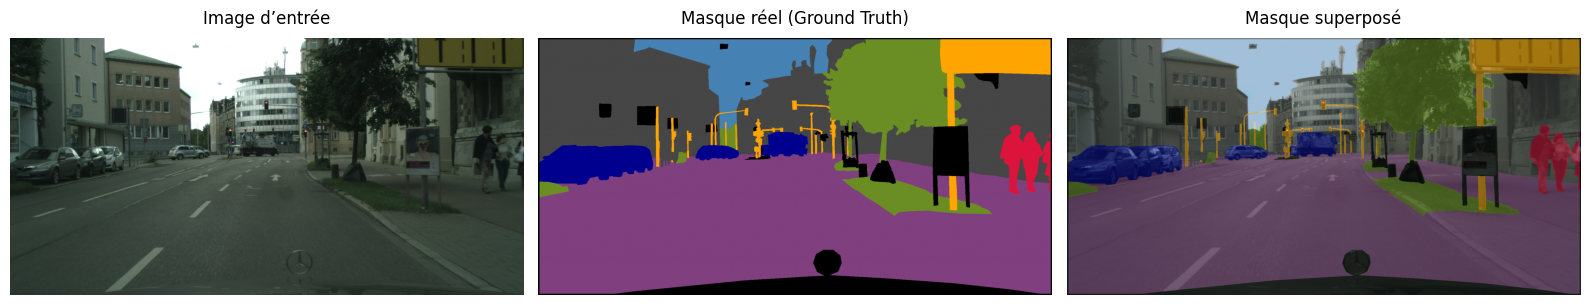

In [131]:
def blend(image, mask, palette):
    color_seg = apply_palette(mask, palette)
    # Fusion image originale (RGB) et masque coloré
    blended = 0.5 * np.array(image, dtype=float) + 0.5 * color_seg
    return blended.astype(np.uint8)

plt.figure(figsize=(16, 10))  # largeur augmentée

plt.subplot(1, 3, 1)
plt.imshow(test_image)
plt.title("Image d’entrée", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(test_segmentation_map, cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque réel (Ground Truth)", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blend(test_image, test_segmentation_map, cityscapes_palette_8))
plt.title("Masque superposé", fontsize=12, pad=10)
plt.axis("off")

plt.tight_layout()
plt.show()

# Préparation des données pour Mask2Former

Avant d’entraîner ou d’évaluer le modèle `Mask2Former`, il est nécessaire de transformer les images et les masques dans un format conforme à ses exigences.

Cette étape repose sur le `Mask2FormerImageProcessor` proposé par Hugging Face, qui automatise les opérations suivantes : normalisation, redimensionnement, et encodage des masques.

* Le modèle utilisé est issu du checkpoint préentraîné `facebook/mask2former-swin-small-cityscapes-semantic`.
* Une fonction `collate_fn()` personnalisée est définie pour appliquer le prétraitement sur chaque batch.
* Des objets `DataLoader` sont ensuite créés pour les jeux de données d'entraînement, de validation et de test, ainsi que pour une version augmentée (`aug_dataset`) utilisée lors des expérimentations.


In [ ]:
checkpoint = "facebook/mask2former-swin-small-cityscapes-semantic"
processor = Mask2FormerImageProcessor.from_pretrained(checkpoint, reduce_labels=False)

def collate_fn(batch):
    # Séparation en deux listes : images et masks
    images, masks = zip(*[list(x.values())[:2] for x in batch])

    # Traitement via processor (pixel_values, pixel_mask, labels, etc.)
    encoded_inputs = processor(
        images=images,
        segmentation_maps=masks,
        return_tensors="pt"
    )

    return encoded_inputs

train_dataloader = DataLoader(datasets['train'], batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(datasets['val'], batch_size=1, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(datasets['test'], batch_size=1, shuffle=False, collate_fn=collate_fn)

data_aug_train_dataloader =  DataLoader(get_dataset('train', 'data/aug_dataset'), batch_size=2, shuffle=True, collate_fn=collate_fn)

Pour mieux comprendre la structure des données générées par le `collate_fn` et le `Mask2FormerImageProcessor`, on récupère un batch à partir du `train_dataloader` et on affiche les dimensions de chaque composant.

In [29]:
batch = next(iter(val_dataloader))

for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])
mask_labels torch.Size([8, 384, 384])
class_labels torch.Size([8])


Une fois les données passées dans le `Mask2FormerImageProcessor`, chaque batch est transformé en une structure complexe contenant plusieurs entrées clés.

* **`pixel_values` (`[1, 3, 384, 384]`)** : Tensor contenant l'image du batch, prétraitées et mises au format attendu par Mask2Former : `(batch_size, channels, height, width)`. Les images sont normalisées selon les statistiques du modèle préentraîné.

* **`pixel_mask` (`[1, 384, 384]`)** : Masque binaire indiquant quels pixels doivent être pris en compte dans le traitement (valeurs à `1`) et lesquels doivent être ignorés (`0`). Ce masque est utile en cas de padding ou de résolution variable.

* **`mask_labels` (`[8, 384, 384]`)** : Tensor contenant les masques binaires individuels extraits des images du batch. Chaque canal représente une instance segmentée (objet ou zone) que le modèle doit apprendre à identifier.

* **`class_labels` (`[8]`)** : Vecteur de classes associé aux 8 masques. Chaque entier correspond à une classe (de `0` à `7` dans notre mapping à 8 classes), indiquant à quelle catégorie appartient chaque masque de `mask_labels`.


In [32]:
# Affichage de la forme du tenseur image après traitement par le processor
pixel_values = batch["pixel_values"][0].numpy()
print("Shape de pixel_values (image normalisée) :", pixel_values.shape)

# Affichage des valeurs uniques de pixel_mask (0 = ignoré, 1 = valide)
print("Valeurs uniques dans pixel_mask :", np.unique(batch["pixel_mask"][0]))

# Affichage des indices de classes présentes dans class_labels
print("Indices des classes présentes dans class_labels :", batch["class_labels"][0])

# Conversion des IDs de classes en labels lisibles
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print("Labels correspondants :", labels)

# Affichage des valeurs uniques dans les masques binaires d’instances
print("Valeurs uniques dans mask_labels :", np.unique(batch["mask_labels"][0]))

Shape de pixel_values (image normalisée) : (3, 384, 384)
Valeurs uniques dans pixel_mask : [1]
Indices des classes présentes dans class_labels : tensor([0, 1, 2, 3, 4, 5, 6, 7])
Labels correspondants : ['void', 'flat', 'construction', 'object', 'nature', 'sky', 'human', 'vehicle']
Valeurs uniques dans mask_labels : [0. 1.]


La fonction `visualize_mask()` permet d’extraire et d’afficher un **masque binaire** correspondant à une classe spécifique (ex : `vehicle`, `construction`, etc.) à partir du batch de données.

In [35]:
def visualize_mask(labels, label_name):
  print(f"Label: {label_name}\n")
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: construction



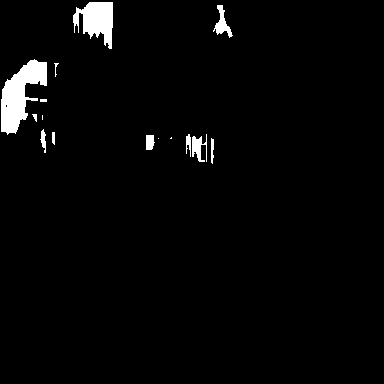

In [37]:
visualize_mask(labels, "construction")

La fonction `reconstruct_segmentation_mask()` permet de reconstruire une **carte de segmentation complète** de dimension `(H, W)` à partir des masques binaires individuels (`mask_labels`) et des labels de classe associés (`class_labels`).

Chaque masque représente une instance d'objet (par exemple une voiture, une personne, etc.), et cette fonction fusionne tous les masques en une seule image de classes où chaque pixel prend la valeur de la classe correspondante.

In [40]:
def reconstruct_segmentation_mask(mask_labels, class_labels):
    h, w = mask_labels[0].shape
    target = torch.zeros((h, w), dtype=torch.long)
    for mask, cls in zip(mask_labels, class_labels):
        target[mask.bool()] = cls
    return target

In [42]:
segmentation_map = reconstruct_segmentation_mask(batch["mask_labels"][0], batch["class_labels"][0])
np.unique(segmentation_map)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

# Utilisation de Mask2Former comme modèle de référence



Pour cette étude, nous nous appuyons sur le modèle `Mask2FormerForUniversalSegmentation`, développé par **Facebook Research** et mis à disposition via la bibliothèque `transformers` de Hugging Face.

Ce modèle, à la pointe des avancées en segmentation d'image, repose sur une architecture **à base de Transformers** et adopte une approche unifiée pour traiter différents types de segmentation (sémantique, instance, panoptique). Il s'appuie sur un mécanisme de **requêtes (queries)** apprises, qui interagissent avec les représentations visuelles de l’image pour produire des **masques** localisés et leurs **classes associées**.

**Fonctionnement du modèle**

Mask2Former suit une architecture modulaire structurée en trois grandes étapes :

1. **Backbone visuel** : un réseau convolutionnel ou un Transformer visuel (typiquement `ResNet` ou `Swin Transformer`) extrait des **caractéristiques multi-échelles** de l'image.

2. **Pixel Decoder** : ces features brutes sont raffinées par un **pixel decoder** (comme `MSDeformAttn`) pour produire une carte d’**embeddings par pixel** à haute résolution. Ces embeddings permettent une reconstruction fine des masques.

3. **Transformer Decoder avec attention masquée** : un ensemble de **requêtes (queries)** interagit avec les embeddings d’image via un mécanisme d’**attention masquée**. Contrairement à une attention globale classique, cette version restreint le champ d’attention de chaque requête à la région d’intérêt qu’elle est censée segmenter, ce qui améliore **la convergence et la qualité des masques**.

Chaque requête génère :

* un **masque binaire** (présence/absence d’objet dans chaque pixel),
* et une **prédiction de classe** pour identifier la catégorie représentée.

**Optimisation du modèle**

L’optimisation repose sur deux types de pertes complémentaires :

* Une **perte de segmentation**, combinant **Dice Loss** et **Binary Cross-Entropy Loss**, appliquée entre chaque masque prédit et son masque de vérité terrain. Elle améliore la précision spatiale des objets segmentés.

* Une **perte de classification**, basée sur la **Cross-Entropy**, qui guide le modèle dans la prédiction correcte de la classe associée à chaque masque.

Avant le calcul de la perte, une étape cruciale de **matching bipartite** est réalisée : chaque prédiction (requête) est associée de manière optimale à une vérité terrain.

Ce couplage garantit une supervision par **correspondance un-à-un**, indispensable pour apprendre à segmenter des objets distincts sans redondance.

Ces pertes sont combinées dans la fonction de perte globale suivante :

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{cls}} + \lambda_{\text{mask}} \cdot \left( \lambda_{\text{CE}} \cdot \mathcal{L}_{\text{BCE}} + \lambda_{\text{Dice}} \cdot \mathcal{L}_{\text{Dice}} \right)
$$

où :

* $\mathcal{L}_{\text{cls}}$ : perte de classification,
* $\mathcal{L}_{\text{BCE}}$ : Binary Cross-Entropy Loss,
* $\mathcal{L}_{\text{Dice}}$ : Dice Loss,
* $\lambda_{\text{mask}}, \lambda_{\text{CE}}, \lambda_{\text{Dice}}$ : coefficients de pondération (par défaut : 2.0, 5.0, 5.0).

Enfin, pour améliorer l’efficacité mémoire et le temps d’entraînement, Mask2Former **n’applique la perte que sur un échantillon de pixels** (via une stratégie de sampling), ce qui permet une **réduction de importante de l’usage GPU** sans dégradation notable des performances.


## Évaluation initiale sans fine-tuning

Dans un premier temps, nous utilisons la version **préentraînée** du modèle, telle quelle, sans aucune mise à jour des poids.
Cela nous permet d’obtenir une **baseline de performance** pour évaluer ses capacités de généralisation sur notre jeu de test.

Ce modèle a été entraîné sur les **19 classes officielles de Cityscapes**, ce qui inclut des catégories détaillées comme `road`, `sidewalk`, `car`, `person`, etc.

L’objectif ici est double :

* **Mesurer les performances brutes** du modèle préentraîné sur des données locales (sans adaptation).
* **Obtenir une première visualisation** des masques prédits, afin d’évaluer qualitativement leur précision et leur structure.

Les prédictions sont affichées sous forme de **masques colorisés**, en suivant une palette donnée.

In [45]:
processor = Mask2FormerImageProcessor.from_pretrained(checkpoint)
pretrained_model = Mask2FormerForUniversalSegmentation.from_pretrained(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_model = pretrained_model.to(device)

La classe ci-dessous encapsule le processus de prédiction avec le modèle `Mask2Former` en utilisant PyTorch et la bibliothèque `transformers`.

Elle est conçue pour travailler avec un dataset contenant des images sous forme de tableaux `numpy` et des dimensions d’origine.

Voici les fonctionnalités principales :

* **Initialisation du modèle** :
  Le modèle est chargé sur le GPU (ou CPU selon le paramètre `device`), avec le `processor` associé pour le prétraitement des images.

* **Méthode `predict()`** :
  Elle prend en entrée un `dataset` et un `index` :

  1. Récupère l'image à l’index donné et la convertit en image `PIL` (attendue par le `processor` Hugging Face).
  2. Applique le prétraitement du `processor` pour générer les tenseurs nécessaires au modèle.
  3. Exécute le modèle en mode évaluation (`torch.no_grad()`).
  4. Applique un post-traitement via `post_process_semantic_segmentation` pour reconstruire le **masque de segmentation** à la taille d’origine de l’image.

Cette abstraction permet de manipuler facilement Mask2Former dans un pipeline expérimental, que ce soit pour des prédictions unitaires ou une évaluation plus large.

In [47]:
# Classe pour effectuer des prédictions avec un modèle Mask2Former (PyTorch + HuggingFace)
class Mask2FormerModel:
    def __init__(self, model, processor, device="cuda"):
        # Initialisation avec le modèle, le processor (pour le prétraitement),
        # et le device (GPU ou CPU)
        self.model = model.to(device)
        self.processor = processor
        self.device = device

    def predict(self, dataset, index):
        # Récupération de l’image du dataset (au format numpy)
        img = dataset[index]['image']
        # Conversion en image PIL pour compatibilité avec le processor
        img = Image.fromarray(img.astype(np.uint8))
        # Encodage avec le processor pour obtenir les entrées du modèle (tensors PyTorch)
        inputs = self.processor(images=img, return_tensors="pt").to(self.device)

        # Prédiction sans calcul de gradients (mode évaluation)
        with torch.no_grad():
            outputs = self.model(**inputs)

        # Récupération de la taille d'origine (H, W) pour la projection de la sortie
        original_size = dataset[index]['original_size']
        # Post-traitement avec le processor pour obtenir le masque prédictif
        pred_mask = self.processor.post_process_semantic_segmentation(
            outputs, target_sizes=[original_size]
        )[0]
        return pred_mask.cpu().numpy()

    def prediction_outputs(self, dataset, index):
        # Récupération de l’image du dataset (au format numpy)
        img = dataset[index]['image']
        # Conversion en image PIL pour compatibilité avec le processor
        img = Image.fromarray(img.astype(np.uint8))
        # Encodage avec le processor pour obtenir les entrées du modèle (tensors PyTorch)
        inputs = self.processor(images=img, return_tensors="pt").to(self.device)

        # Prédiction sans calcul de gradients (mode évaluation)
        with torch.no_grad():
            return self.model(**inputs)

#### Visualisation des prédictions avec les 19 classes d’origine

Mask2Former a été préentraîné sur Cityscapes pour prédire **19 classes sémantiques** correspondant à l’annotation complète du dataset (ex : *road*, *car*, *bike*, *person*, etc.).

Dans cette première étape, nous visualisons les **prédictions brutes** du modèle, sans transformation ni remappage.

Pour cela :

* Chaque pixel est colorisé à l’aide de la **palette RGB officielle de Cityscapes (19 classes)**.
* Le masque est affiché tel que produit par le `post_process_semantic_segmentation()` du processor Hugging Face.
* L’objectif est d’avoir un premier aperçu qualitatif du comportement du modèle sur des images du jeu de test.

In [51]:
# Palette Cityscapes RGB (19 classes)
cityscapes_palette_19 = [
    (128, 64, 128), (244, 35, 232), (70, 70, 70), (102, 102, 156),
    (190, 153, 153), (153, 153, 153), (250, 170, 30), (220, 220, 0),
    (107, 142, 35), (152, 251, 152), (70, 130, 180), (220, 20, 60),
    (255, 0, 0), (0, 0, 142), (0, 0, 70), (0, 60, 100),
    (0, 80,100), (0, 0,230), (119, 11, 32)
]
cmap_cityscapes_19 = ListedColormap(np.array(cityscapes_palette_19) / 255.0)

cityscapes_classes_19 = [
    "road", "sidewalk", "building", "wall", "fence", "pole",
    "traffic light", "traffic sign", "vegetation", "terrain",
    "sky", "person", "rider", "car", "truck", "bus", "train",
    "motorcycle", "bicycle"
]

def create_color_mask(mask, palette):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in enumerate(palette):
        color_mask[mask == class_id] = color
    return color_mask

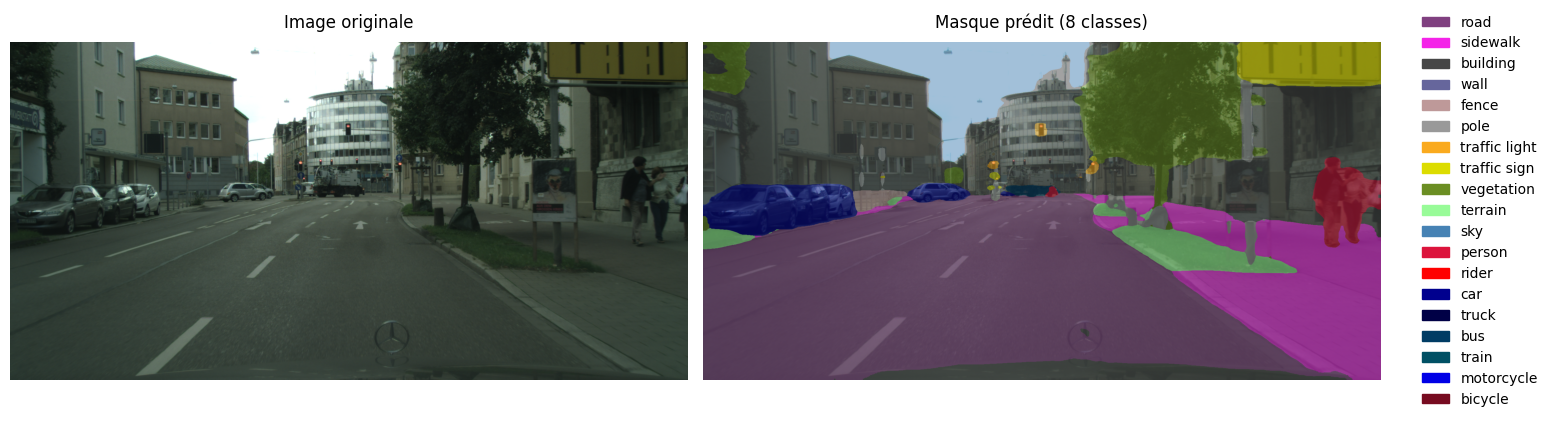

In [53]:
mask = datasets['test'][img_index_test]['mask']

img = datasets['test'][img_index_test]['image']
img = Image.fromarray(img.astype(np.uint8))

mask2former = Mask2FormerModel(pretrained_model, processor)
pred_mask2former = mask2former.predict(datasets['test'], img_index_test)
pred_mask2former_rgb = create_color_mask(pred_mask2former, cityscapes_palette_19)

fig = plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image originale", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(blend(img, pred_mask2former, cityscapes_palette_19), cmap=cmap_cityscapes_19, vmin=0, vmax=18)
plt.title("Masque prédit (8 classes)", fontsize=12, pad=10)
plt.axis("off")

handles = [mpatches.Patch(color=np.array(c)/255.0, label=label) for c, label in zip(cityscapes_palette_19, cityscapes_classes_19)]
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

### Remapping des prédictions vers 8 classes

Afin de comparer le modèle Mask2Former au modèle DilatedNet (entraîné sur une version simplifiée à 8 classes), il est nécessaire de **projeter les prédictions à 19 classes vers un espace réduit à 8 classes**.

Ce remapping s'effectue en appliquant un dictionnaire de conversion (`cityscapes_19_to_8_mapping`) qui regroupe plusieurs classes fines en grandes catégories générales telles que `construction`, `nature`, ou `vehicle`.

Nous utilisons ensuite une **palette personnalisée de 8 couleurs** pour visualiser les prédictions remappées.

In [55]:
# Mapping pour le masque prédit (trainIds 0-18)
cityscapes_19_to_8_mapping = {
    0: 1, 1: 1,               # flat
    2: 2, 3: 2, 4: 2,         # construction
    5: 3, 6: 3, 7: 3,         # object
    8: 4, 9: 4,               # nature
    10: 5,                    # sky
    11: 6, 12: 6,             # human
    13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7  # vehicle
}

def remap_cityscapes_to_8classes(mask):
    remapped = np.full_like(mask, fill_value=255)
    for train_id, new_id in cityscapes_19_to_8_mapping.items():
        remapped[mask == train_id] = new_id
    return remapped

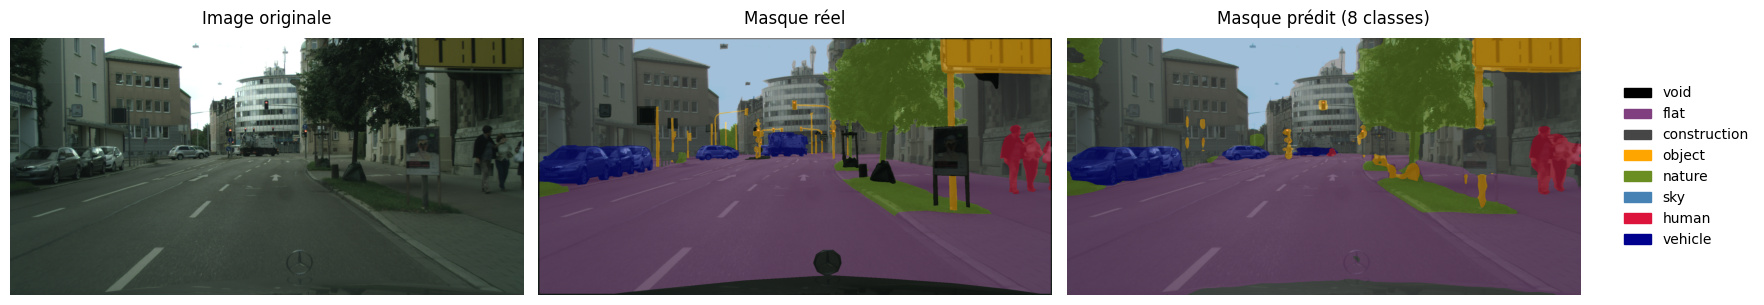

In [56]:
mask = datasets['test'][img_index_test]['mask']

img = datasets['test'][img_index_test]['image']
img = Image.fromarray(img.astype(np.uint8))

mask2former = Mask2FormerModel(pretrained_model, processor)
pred_mask2former = mask2former.predict(datasets['test'], img_index_test)
pred_mask2former = remap_cityscapes_to_8classes(pred_mask2former)
pred_mask2former_rgb = create_color_mask(pred_mask2former, cityscapes_palette_8)

fig = plt.figure(figsize=(16, 10))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Image originale", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(blend(img, mask, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque réel", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(blend(img, pred_mask2former, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque prédit (8 classes)", fontsize=12, pad=10)
plt.axis("off")

handles = [mpatches.Patch(color=np.array(c)/255.0, label=label) for c, label in zip(cityscapes_palette_8, cityscapes_classes_8)]
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

Le modèle parvient à segmenter correctement les **classes dominantes** comme :

* `flat` (route, en mauve),
* `nature` (végétation, en vert),
* `vehicle` (voitures, en bleu foncé),
* et `sky` (en bleu clair).

En revanche, la **classe `void`** (noir) n’est **jamais prédite**, ce qui est **attendu** :

Elle n’existe pas dans les 19 classes d’origine de Cityscapes, donc **le modèle n’a pas été entraîné pour l’identifier**.

Cette limitation souligne l’importance d’un **fine-tuning spécifique**, qui permet au modèle d’apprendre à reconnaître des classes absentes de son entraînement initial, comme `void`, et à mieux s’aligner sur la distribution réelle de notre dataset cible.

### Évaluation et calcul des métriques

Pour évaluer les performances de `Mask2Former`, il ne suffit pas d’extraire une carte de classes par pixel comme avec un U-Net ou DilatedNet.
Le modèle repose sur une approche **par requêtes (queries)**, combinant une prédiction de classe et un masque par segment.

Concrètement, deux sorties principales sont générées :

* **`class_queries_logits`** : scores de classification associés à chaque segment proposé (requête).
  → Shape : `[batch_size, num_queries, num_classes]`.

* **`masks_queries_logits`** : masques associés à chaque requête, exprimés en logits pour chaque pixel.
  → Shape : `[batch_size, num_queries, height, width]`.

Chaque **requête** représente une hypothèse : "ce segment correspond à cette classe".
La segmentation finale est obtenue en **pondérant les masques par leurs scores de classe**, puis en sélectionnant la **classe dominante pixel par pixel**.
Cette opération est réalisée par la méthode `post_process_semantic_segmentation()` du processor Hugging Face.


Puisque notre objectif est de **comparer Mask2Former à DilatedNet**, nous remappons les sorties du modèle depuis les 19 classes officielles Cityscapes vers les **8 grandes classes** utilisées dans notre version simplifiée.
Cela permet une comparaison équitable sur les mêmes masques cibles.

La fonction `evaluate_mask2former()` réalise ce processus en plusieurs étapes :

1. **Prétraitement & inférence** :
   * Mise en mode évaluation (`model.eval()`), envoi sur le `device`.
   * Prédiction des masques bruts à 19 classes.
   * Remapping en 8 classes via un dictionnaire dédié.

2. **Préparation des masques ground-truth** :
   * Reconstruction à partir des `mask_labels` et `class_labels`.
   * Application d’un masque de validité pour **ignorer optionnellement les pixels `void` ou inconnus (255)\`**.

3. **Calcul des métriques "discrètes"** :
   * Conversion des prédictions en classes (`argmax`).
   * Comparaison aux masques ground-truth pour calculer :
     * `accuracy` (précision pixel),
     * `dice_macro` (moyenne des scores Dice par classe),
     * `dice_per_class` (score Dice individuel).

4. **Calcul du `dice_global` (probabiliste)** :
   * Reconstruction d’une **prédiction soft** (logits combinés par `einsum`).
   * Remapping 19 → 8 classes directement sur les logits (optionnel selon le type de sortie du modèle).
   * Comparaison avec les **ground-truth one-hot** pour obtenir un **Dice agrégé** sur l’ensemble de l’image.

L’option `ignore_void` permet d’exclure tous les pixels de classe `0` (void) du calcul.
Cela est utile car **aucune des 19 classes d’origine prédite par Mask2Former ne correspond à la catégorie `void`** définie dans notre regroupement à 8 classes.
Inclure cette classe dans l’évaluation reviendrait donc à sanctionner le modèle pour une classe qu’il n’est pas censé reconnaître, ce qui fausserait les résultats.

In [61]:
mlflow.set_tracking_uri("mlruns")

experiment_name = "Segmentation Images (Dilatednet vd Mask2Former)"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/Rafik/AI/AI_Projects/9/mlruns/306956193566179235', creation_time=1746371582388, experiment_id='306956193566179235', last_update_time=1746371582388, lifecycle_stage='active', name='Segmentation Images (Dilatednet vd Mask2Former)', tags={}>

In [63]:
def compute_dice(preds_all, labels_all, n_classes=8, ignore_void=True):
    dices = []
    for cls in range(n_classes):
        if ignore_void and cls == 0:
            continue
        pred_cls = (preds_all == cls).astype(np.uint8)
        label_cls = (labels_all == cls).astype(np.uint8)
        intersection = np.sum(pred_cls * label_cls)
        total = np.sum(pred_cls) + np.sum(label_cls)
        dice = (2 * intersection + 1e-5) / (total + 1e-5)
        dices.append(dice)
    return dices

def dice_coeff_global(y_true, y_pred, ignore_void=False, smooth=1.0):
    if ignore_void:
        y_true = y_true[1:]  # enlève la première classe (void)
        y_pred = y_pred[1:]

    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)

    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def compute_inference_runtime(model, dataloader, device="cuda"):
    model.to(device)
    model.eval()

    total_time = 0.0
    total_images = 0

    for batch in tqdm(dataloader, desc="Mesure du temps d'inférence"):
        batch = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}
        batch_size = batch["pixel_values"].size(0)

        start = time.time()
        with torch.no_grad():
            _ = model(**batch)
        end = time.time()

        total_time += (end - start)
        total_images += batch_size

    return total_time / total_images
    
def evaluate_mask2former(model, dataloader, processor, device="cuda", ignore_void=True):
    model.to(device).eval()
    preds_all, labels_all = [], []         # Pour Dice/Acc par pixel
    y_true_all, y_pred_all = [], []        # Pour Dice global soft (probabiliste)

    for batch in tqdm(dataloader, desc="Évaluation"):
        # Préparation des inputs
        inputs = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

        with torch.no_grad():
            outputs = model(**inputs)

        remap_classes = outputs['class_queries_logits'].shape[2] > len(cityscapes_classes_8) + 1 

        # Taille d’origine
        h, w = batch["pixel_mask"].shape[-2:]
        target_sizes = [(h, w)] * batch["pixel_values"].shape[0]

        # Masques prédits (argmax)
        pred_masks = processor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

        for i in range(len(pred_masks)):
            pred_mask = torch.from_numpy(pred_masks[i]).to(device).clone().detach()
            gt_mask = reconstruct_segmentation_mask(batch["mask_labels"][i], batch["class_labels"][i]).to(device)

            # Remap 19 → 8 classes (si demandé)
            pred_remapped = (
                torch.tensor(remap_cityscapes_to_8classes(pred_mask.cpu().numpy()), device=device)
                if remap_classes else pred_mask
            )

            # Filtrage void / ignore
            valid_mask = (gt_mask != 255)
            if ignore_void:
                valid_mask &= (gt_mask != 0)

            # Données pour Dice par classe et accuracy
            pred_valid = pred_remapped[valid_mask]
            label_valid = gt_mask[valid_mask]
            preds_all.append(pred_valid)
            labels_all.append(label_valid)

            # Segmentation probabiliste (logits → proba)
            class_probs = outputs.class_queries_logits[i].softmax(dim=-1)
            mask_probs = outputs.masks_queries_logits[i].sigmoid()

            segmentation_logits = torch.einsum("qc,qhw->chw", class_probs[:mask_probs.shape[0]], mask_probs)
            segmentation_logits = torch.nn.functional.interpolate(
                segmentation_logits.unsqueeze(0), size=(h, w), mode="bilinear", align_corners=False
            ).squeeze(0)

            # Remap proba 
            if remap_classes:
                segmentation_logits_8 = torch.zeros((8, h, w), device=device)
                for old_class, new_class in cityscapes_19_to_8_mapping.items():
                    segmentation_logits_8[new_class] += segmentation_logits[old_class]
            else:
                segmentation_logits_8 = segmentation_logits[:8]

            # GT one-hot
            gt_onehot = torch.nn.functional.one_hot(gt_mask, num_classes=8).permute(2, 0, 1)
            
            # Filtrage pixels valides
            y_pred_all.append(segmentation_logits_8[:, valid_mask])
            y_true_all.append(gt_onehot[:, valid_mask])

    # Concaténation pour métriques classiques
    preds_all = torch.cat(preds_all).cpu().numpy()
    labels_all = torch.cat(labels_all).cpu().numpy()
    acc = accuracy_score(labels_all, preds_all)

    # Dice par classe
    dices = compute_dice(preds_all, labels_all, n_classes=8, ignore_void=ignore_void)
    class_labels = cityscapes_classes_8[1 if ignore_void else 0:]
    dice_macro = sum(dices) / len(dices)

    # Dice global (soft) sur logits
    y_pred_all = torch.cat(y_pred_all, dim=1)
    y_true_all = torch.cat(y_true_all, dim=1)
    dice_global = dice_coeff_global(y_true_all, y_pred_all, ignore_void).item()

    # Affichage console
    print(f"Accuracy     : {acc:.4f}")
    print(f"Dice global  : {dice_global:.4f}")
    print(f"Dice moyen   : {dice_macro:.4f}")

    return {
        "accuracy": acc,
        "dice_macro": dice_macro,
        "dice_global": dice_global,
        "dice_per_class": dict(zip(class_labels, dices))
    }

Dans cette section, on évalue les performances du modèle Mask2Former **pré-entraîné tel quel**, appliqué à une version remappée à 8 classes du dataset Cityscapes.

Deux évaluations sont réalisées :
- une **avec inclusion de la classe `void`**
- une **en ignorant la classe `void`** (utile pour se concentrer sur les vraies classes segmentables)

Les métriques sont loggées dans MLflow pour analyse comparative.

In [ ]:
for ignore_void in [True, False]:

    with mlflow.start_run():
    
        mlflow.log_params({
            "model": "mask2former",
            "training_type": "pretrained",
            "ignore_void": ignore_void,
        })
        
        metrics = evaluate_mask2former(pretrained_model, test_dataloader, processor, device='cuda', ignore_void=ignore_void)
    
        mlflow.log_metric("test_accuracy", metrics["accuracy"])
        mlflow.log_metric("test_dice", metrics["dice_global"])
        mlflow.log_metric("test_mean_dice", metrics["dice_macro"])
        for cls, score in metrics["dice_per_class"].items():
            mlflow.log_metric(f"dice_{cls.lower().replace(' ', '_')}", score)
        mlflow.log_dict(metrics["dice_per_class"], "dice_per_class.json")
    
        inference_runtime = compute_inference_runtime(pretrained_model, test_dataloader, device="cuda")
        mlflow.log_metric("inference_runtime", inference_runtime)
    
        mlflow.end_run()

## Fine-tuning du modèle

Dans cette phase, nous appliquons un **fine-tuning ciblé** de Mask2Former sur une version remappée à 8 classes du dataset Cityscapes.

Nous testons deux variantes : un **entraînement complet du modèle** et un **entraînement partiel** dans lequel nous **gelons le backbone (`Swin Transformer`)** pour n’entraîner que les couches responsables de la segmentation finale :
le **décodeur transformeur**, la **projection des masques** (`mask_embedder`) et la **tête de classification** (`class_predictor`).

Ce choix permet de comparer l’impact du gel du backbone, notamment en termes de performance, de généralisation et de risque de surapprentissage.

En effet :

* Les **features visuelles extraites par le backbone** sont génériques, robustes et adaptées à notre tâche : inutile de les réapprendre dans certains cas.
* Le **remapping des 19 vers 8 classes**, avec l’introduction de `void`, nécessite plutôt d’**adapter la logique d’interprétation des queries** que l’extraction des patterns visuels.
* Geler le backbone peut aussi **réduire le risque de surapprentissage** (notre dataset est de taille modeste), tout en **profitant pleinement du pré-entraînement** sur Cityscapes.

L'entraînement est suivi avec **MLflow** pour tracer les pertes, les métriques, et sauvegarder les versions du modèle à chaque époque.

La fonction `move_to_device` assure le **transfert complet d’un batch sur le bon `device`** (`cuda` ou `cpu`), quelle que soit sa structure.
Elle est indispensable pour garantir la compatibilité du batch avec un modèle PyTorch exécuté sur GPU.

Elle prend en charge les cas suivants :

* **Tenseur simple (`torch.Tensor`)** : transféré directement via `.to(device)`.
* **Liste de tenseurs** (ex. `mask_labels`, `class_labels`) : chaque élément est transféré individuellement.
* **Liste de listes de tenseurs** : prise en charge récursive pour assurer le transfert en profondeur.

Ce traitement robuste permet d’éviter les erreurs classiques liées à des objets restés sur le CPU lorsque le modèle est sur le GPU.

In [67]:
def move_to_device(batch, device):
    for k, v in batch.items():
        if isinstance(v, torch.Tensor):
            batch[k] = v.to(device)
        elif isinstance(v, list):
            # Liste de Tensors (ex : mask_labels[i] = [Tensor, Tensor, ...])
            if len(v) > 0 and isinstance(v[0], torch.Tensor):
                batch[k] = [x.to(device) for x in v]
            # Liste de listes de Tensors (rare ici mais possible)
            elif len(v) > 0 and isinstance(v[0], list) and isinstance(v[0][0], torch.Tensor):
                batch[k] = [[x.to(device) for x in inner] for inner in v]
    return batch

print("pixel_values device:", batch["pixel_values"].device)
print("mask_labels[0] device:", batch["mask_labels"][0][0].device)

batch = move_to_device(batch, device)

print("pixel_values device:", batch["pixel_values"].device)
print("mask_labels[0] device:", batch["mask_labels"][0][0].device)

pixel_values device: cpu
mask_labels[0] device: cpu
pixel_values device: cuda:0
mask_labels[0] device: cuda:0


Ces deux fonctions utilitaires permettent de **surveiller et libérer la mémoire GPU** utilisée lors de l'entraînement ou de l'inférence.

* `clean_gpu_memory()` :

  * Vide la mémoire inutilisée sur le GPU à l’aide de `torch.cuda.empty_cache()`.
  * Appelle également `torch.cuda.ipc_collect()` pour libérer les handles inter-processus CUDA.
  * Exécute un `gc.collect()` pour nettoyer les objets inutilisés du côté CPU.
  * Cette fonction est utile pour prévenir les erreurs de type *out of memory* lors des cycles d’entraînement ou des évaluations répétées.

* `print_gpu_memory()` :

  * Affiche un résumé de l’état actuel de la mémoire du GPU :

    * Mémoire totale,
    * Mémoire réservée par PyTorch,
    * Mémoire réellement allouée,
    * Mémoire encore disponible.
  * Cela permet de diagnostiquer l’usage mémoire du modèle ou de détecter des fuites potentielles entre les époques.

Ces fonctions sont généralement appelées **avant chaque époque** pour garantir un environnement mémoire propre.

In [70]:
def clean_gpu_memory():
    gc.collect()                        # Nettoie la mémoire CPU
    torch.cuda.empty_cache()           # Libère la mémoire non utilisée GPU
    torch.cuda.ipc_collect()           # Nettoie les handles CUDA inter-processus
    #print("Mémoire GPU libérée.\n")

def print_gpu_memory():
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        total = torch.cuda.get_device_properties(device).total_memory
        reserved = torch.cuda.memory_reserved(device)
        allocated = torch.cuda.memory_allocated(device)
        free = reserved - allocated

        print(f"GPU: {torch.cuda.get_device_name(device)}")
        print(f"Mémoire totale    : {total / 1024**3:.2f} Go")
        print(f"Mémoire réservée  : {reserved / 1024**3:.2f} Go")
        print(f"Mémoire allouée  : {allocated / 1024**3:.2f} Go")
        print(f"Mémoire libre     : {free / 1024**3:.2f} Go")
    else:
        print("GPU non disponible.")

clean_gpu_memory()
print_gpu_memory()

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Mémoire totale    : 6.00 Go
Mémoire réservée  : 0.28 Go
Mémoire allouée  : 0.27 Go
Mémoire libre     : 0.01 Go


Le code ci-dessous active plusieurs **optimisations spécifiques à CUDA** afin d'améliorer les performances d'entraînement et de débogage avec PyTorch :

* `torch.backends.cudnn.benchmark = True`
  Active un mode de benchmarking de `cuDNN` pour sélectionner automatiquement l'algorithme le plus rapide selon les dimensions des entrées. Cela améliore la vitesse lorsque les tailles d'entrée sont constantes d’un batch à l’autre.

* `torch.backends.cudnn.enabled = True`
  Assure que `cuDNN` est bien utilisé (ce qui est normalement le cas par défaut).

* `os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"`
  Active une configuration avancée de l’allocation mémoire de PyTorch qui réduit la fragmentation mémoire sur le GPU. Cela permet une meilleure réutilisation de la mémoire et évite certains plantages dus à l'épuisement apparent de mémoire.

* `os.environ["CUDA_LAUNCH_BLOCKING"] = "1"`
  Force l'exécution synchrone des opérations CUDA, utile pour **déboguer les erreurs** en localisant précisément l’opération fautive (au prix d’un ralentissement significatif). Il est recommandé de désactiver cette option (`"0"`) une fois le code stable.

In [73]:
# Optimisation CUDA

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

Le code ci-dessous effectue le **fine-tuning de Mask2Former** sur le dataset Cityscapes réduit à 8 classes, avec un suivi complet des performances via `MLflow`.

Le modèle est entraîné à l’aide de l’optimiseur **Adam** (`lr = 5e-5`) et d’un `DataLoader` configuré pour appliquer ou non des **augmentations de données**. La classe `void` est incluse dans les calculs de perte et d’évaluation (`ignore_void = False`).

À chaque époque :

* Le **loss d'entraînement moyen** est calculé et loggé (`train_loss`)
* Une **évaluation sur le jeu de validation** est effectuée :

  * Dice global (`val_dice`)
  * Accuracy (`val_accuracy`)

À la fin de l'entraînement :

* Le **modèle est sauvegardé** avec `mlflow.pytorch.log_model()`
* Une **évaluation finale** est menée sur l’ensemble de test :

  * Dice global (`test_dice`)
  * Dice macro (moyenne par classe)
  * Accuracy (`test_accuracy`)
  * Dice par classe, enregistré à la fois en métriques individuelles et en dictionnaire (`dice_per_class.json`)
* Le **temps d’inférence moyen par image** est mesuré et loggé (`inference_runtime`)
* Le **temps total d'entraînement** est également enregistré (`train_runtime`)

Tous ces éléments sont centralisés dans MLflow pour permettre une **traçabilité complète**, une **comparaison rigoureuse entre versions** du modèle, et une **visualisation des performances détaillées**.

In [76]:
def train_and_log_mask2former(model, num_epochs, training_type, data_augmentation):

    with mlflow.start_run():
        
        # Paramètres d'entraînement
        ignore_void = False
        lr = 5e-5

        dataloader = data_aug_train_dataloader if data_augmentation else train_dataloader

        # Enregistrement des hyperparamètres dans MLflow
        mlflow.log_params({
            "model": "mask2former",
            "lr": lr,
            "optimizer": "Adam",
            "batch_size": dataloader.batch_size,
            "epoch": num_epochs,
            "training_type": training_type,
            "data_augmentation": True,
            "ignore_void": ignore_void
        })
        
        # Initialisation de l'optimiseur
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
        start_time = time.time()
    
        for epoch in range(num_epochs):
            clean_gpu_memory()
            #print_gpu_memory()
            
            print(f"\nEpoch {epoch + 1}")
            model.train()
            running_loss = 0.0
            num_samples = 0
    
            # Entraînement par batch
            for idx, batch in enumerate(tqdm(dataloader)):
                optimizer.zero_grad()
                batch = move_to_device(batch, device)
    
                # Propagation avant
                outputs = model(
                  pixel_values=batch["pixel_values"],
                  mask_labels=batch["mask_labels"],
                  class_labels=batch["class_labels"],
                )
    
                # Calcul de la perte et rétropropagation
                loss = outputs.loss
                loss.backward()
                optimizer.step()
    
                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
    
                #if idx % 100 == 0:
                #    print("Loss:", running_loss / num_samples)
    
            # Calcul de la perte moyenne sur l'époque
            train_loss = running_loss / num_samples
            mlflow.log_metric("train_loss", train_loss, step=epoch)
    
            # Évaluation sur l'ensemble de validation
            model.eval()
            metrics = evaluate_mask2former(model, val_dataloader, processor, device='cuda', ignore_void=ignore_void)
            dice = metrics['dice_global']
            accuracy = metrics['accuracy']
    
            # Enregistrement des métriques de validation
            mlflow.log_metric("val_dice", dice, step=epoch)
            mlflow.log_metric("val_accuracy", accuracy, step=epoch)
    
        # Enregistrement du temps total d'entraînement
        end_time = time.time()
        mlflow.log_metric("train_runtime", end_time - start_time)
    
        # Sauvegarde du modèle entraîné dans MLflow
        example_batch = next(iter(val_dataloader))
        X = example_batch["pixel_values"].detach().cpu().numpy()
        signature = infer_signature(X)
        mlflow.pytorch.log_model(model, 'mask2former', signature=signature, pip_requirements=[])
    
        # Évaluation finale sur l'ensemble de test
        metrics = evaluate_mask2former(model, test_dataloader, processor, device='cuda', ignore_void=ignore_void)
        
        mlflow.log_metric("test_dice", metrics['dice_global'])
        mlflow.log_metric("test_mean_dice", metrics['dice_macro'])
        mlflow.log_metric("test_accuracy", metrics['accuracy'])
    
        for cls, score in metrics["dice_per_class"].items():
            mlflow.log_metric(f"dice_{cls.lower().replace(' ', '_')}", score)
        mlflow.log_dict(metrics["dice_per_class"], "dice_per_class.json")
    
        inference_runtime = compute_inference_runtime(model, test_dataloader, device="cuda")
        mlflow.log_metric("inference_runtime", inference_runtime)
        
        mlflow.end_run()

### Entraînement complet du modèle (fine-tuning total)

In [ ]:
# Chargement du modèle pré-entraîné avec adaptation à 8 classes
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

# Envoi du modèle sur le bon device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"\nModèle Mask2Former chargé et adapté pour 8 classes.\nUtilisation du device : {device}\n")

# Vérification du bon fonctionnement avec un forward pass
outputs = model(**batch)
print(f"Valeur initiale de la loss : {outputs.loss:.4f}")

In [ ]:
train_and_log_mask2former(model, num_epochs=3, training_type="fine_tuned", data_augmentation=False)

### Entraînement avec backbone gelé (fine-tuning partiel)

In [ ]:
# Chargement du modèle pré-entraîné avec adaptation à 8 classes
model = Mask2FormerForUniversalSegmentation.from_pretrained(
    checkpoint,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

# Envoi du modèle sur le bon device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"\nModèle Mask2Former chargé et adapté pour 8 classes.\nUtilisation du device : {device}\n")

# Vérification du bon fonctionnement avec un forward pass
outputs = model(**batch)
print(f"Valeur initiale de la loss : {outputs.loss:.4f}")

In [ ]:
def freeze_backbone_only(model):
    for name, param in model.named_parameters():
        # Geler uniquement l'encodeur visuel
        if "pixel_level_module.encoder" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    print("Backbone (encoder) gelé. Decoder, transformer et tête de prédiction sont entraînables.")

def print_trainable_summary(model):
    total, trainable = 0, 0
    for name, param in model.named_parameters():
        num_params = param.numel()
        total += num_params
        if param.requires_grad:
            trainable += num_params
            print(f"[TRAINABLE] {name} ({num_params} paramètres)")
        else:
            print(f"[FROZEN]    {name} ({num_params} paramètres)")
    print(f"\nTotal paramètres : {total:,}")
    print(f"Paramètres entraînables : {trainable:,} ({trainable / total:.2%})")

freeze_backbone_only(model)

print_trainable_summary(model)

In [ ]:
train_and_log_mask2former(model, num_epochs=3, training_type="frozen_backbone", data_augmentation=False)

# Comparaison des modèles (Mask2Former vs Dilatednet)

In [83]:
def load_mlflow_best_results(experiment_name):
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs_df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

    def seconds_to_hhmm(seconds):
        try:
            m, s = divmod(int(seconds), 60)
            h, m = divmod(m, 60)
            return f"{h}h{m:02d}m"
        except:
            return "N/A"

    # Formatage des durées
    runs_df['metrics.train_runtime'] = runs_df['metrics.train_runtime'].apply(seconds_to_hhmm)
    runs_df['metrics.inference_runtime'] = runs_df['metrics.inference_runtime'].apply(lambda x: f'{int(1000 * x)} ms')

    # Clés d'identification d'une config
    key_cols = ['params.training_type', 'params.model', 'params.epoch', 'params.ignore_void']

    # Garder le meilleur test_dice pour chaque combinaison unique, y compris celles avec des valeurs nulles
    best_runs_df = (
        runs_df.sort_values("metrics.test_dice", ascending=False)
               .groupby(key_cols, as_index=False, dropna=False)
               .first()
               .fillna('N/A')
               .reset_index(drop=True)
    )

    best_runs_df.sort_values("metrics.test_dice", ascending=False, inplace=True)
    return best_runs_df

## Résultats globaux

Les performances globales des différents modèles sont synthétisées dans le tableau ci-dessous.

On compare ici les versions pré-entraînées et fine-tunées de Mask2Former, ainsi qu’un modèle DilatedNet entièrement entraîné.

In [ ]:
results = load_mlflow_best_results(experiment_name)

best_run_id = results.to_dict('records')[0]['run_id']

model_uri = f'runs:/{best_run_id}/mask2former'

best_model = mlflow.pytorch.load_model(model_uri)

In [87]:
columns = ['run_id', 'params.model', 'params.training_type', 'params.batch_size', 'params.epoch', 'params.ignore_void', 'metrics.test_accuracy', 'metrics.test_dice', 'metrics.train_runtime', 'metrics.inference_runtime']

results[columns]

,run_id,params.model,params.training_type,params.batch_size,params.epoch,params.ignore_void,metrics.test_accuracy,metrics.test_dice,metrics.train_runtime,metrics.inference_runtime
1,e5e9cc5e6b7847948aaddfd34ae4fbc8,mask2former,fine_tuned,2,3,False,0.933282,0.948166,1h48m,142 ms
2,9625932533e441b3a4bb1e79687f01c7,mask2former,frozen_backbone,2,1,False,0.933065,0.932180,0h30m,136 ms
3,227d89813b8246a08a30c4ab597f82f2,mask2former,frozen_backbone,2,3,False,0.933910,0.925087,1h38m,136 ms
6,4b6b9843338447a092ce5d03b9ed65b8,mask2former,pretrained,N/A,N/A,True,0.955643,0.921074,0h00m,151 ms
0,d44bb1ea8dc24a6885b722251ecdcf99,mask2former,fine_tuned,2,1,False,0.923060,0.920309,0h34m,139 ms
5,9c64519ff9cc4ed3ae9be1e8ca9df99d,mask2former,pretrained,N/A,N/A,False,0.857906,0.861401,0h00m,152 ms
4,ea29351355114229b5159bbd067bc04b,dilatednet,fully_trained,8,5,N/A,0.853981,0.828020,1h30m,138 ms


Le tableau met en évidence plusieurs enseignements clés concernant les performances de **Mask2Former** et **DilatedNet**, selon différentes stratégies d'entraînement.

* Le **fine-tuning complet** de Mask2Former sur 3 époques atteint les **meilleurs scores globaux**, avec un **Dice de 94.82 %** et une **précision pixel de 93.33 %**, au prix d’un temps d’entraînement plus long (1h48m). Ce résultat confirme l’efficacité du modèle une fois pleinement adapté aux spécificités de l’annotation 8 classes.

* Fait notable, le **backbone gelé avec seulement 1 époque** donne de **meilleurs résultats (Dice 93.22 %)** que la même configuration entraînée sur 3 époques (Dice 92.51 %). Cela suggère un **risque de surapprentissage** dès les premières itérations lorsque seules les couches supérieures sont entraînées. Cette stratégie reste néanmoins intéressante pour son **excellent rapport performance / temps d’entraînement** (30 minutes seulement).

* Le **modèle pré-entraîné** (sans fine-tuning) affiche une **très bonne précision pixel (95.56 %)**, mais un Dice global plus faible (92.11 %), ce qui indique une **bonne capacité à segmenter les grandes classes dominantes**, mais une **faible adaptation aux classes spécifiques ou rares**, comme `object`.

* En comparaison, **DilatedNet**, même entraîné 5 époques, reste en retrait avec un **Dice de 82.80 %** et une **précision pixel de 85.40 %**, ce qui confirme les limites du modèle en termes de finesse spatiale et de généralisation.

* Les **temps d’inférence** sont similaires pour tous les modèles (\~135–152 ms), ce qui confirme que le gain de qualité de Mask2Former ne se fait **pas au détriment de la rapidité**.

Ce tableau met en évidence la **supériorité nette de Mask2Former**, même sans fine-tuning. Il montre aussi que **le gel du backbone combiné à un entraînement léger** peut suffire à obtenir d’excellentes performances, tout en **gardant un coût de calcul comparable**.

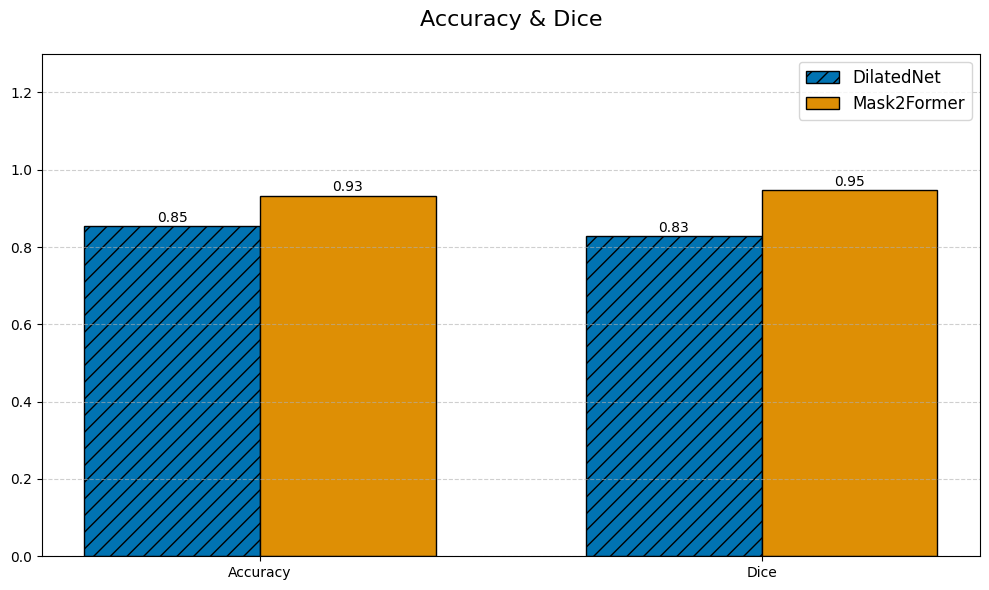

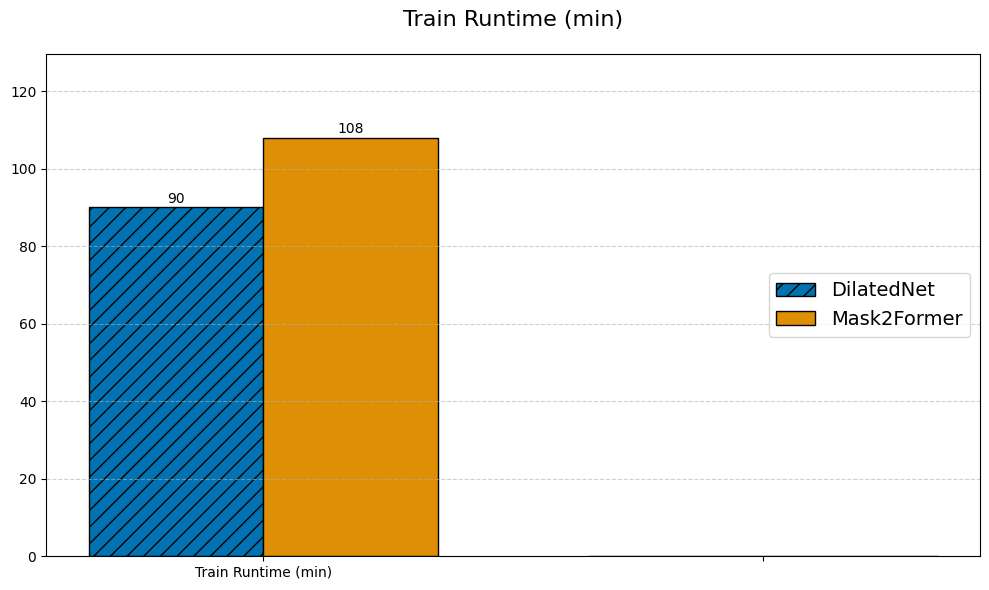

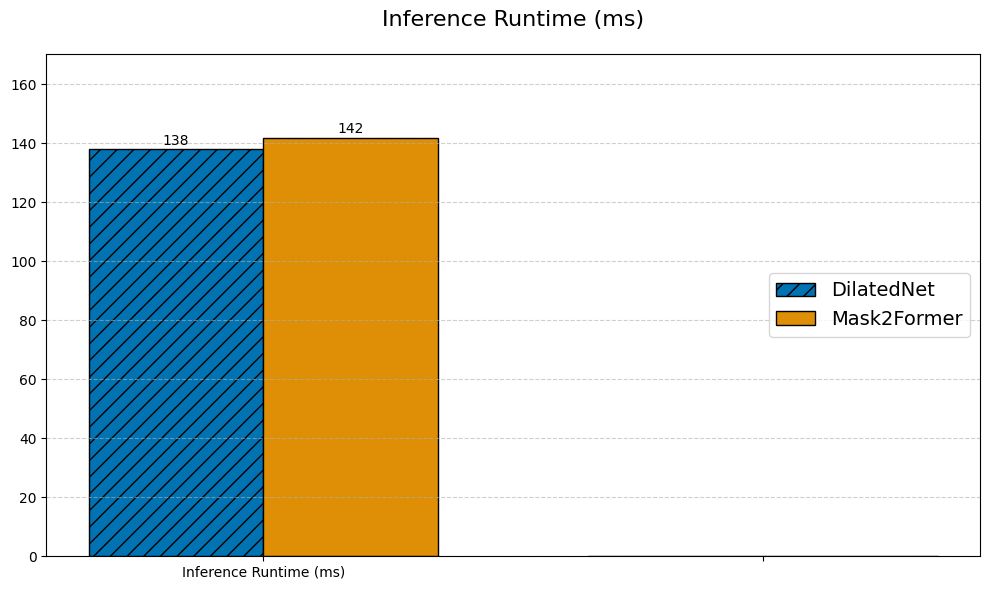

In [91]:
df = results.copy()

best_mask2former = df[(df['params.model'] == 'mask2former') & (df['params.training_type'] == 'fine_tuned')].to_dict('records')[0]
best_dilatednet = df[df['params.model'] == 'dilatednet'].to_dict('records')[0]

# Extraire et convertir les métriques globales
metrics = ['metrics.test_accuracy', 'metrics.test_dice', 'metrics.train_runtime', 'metrics.inference_runtime']
labels = ['Accuracy', 'Dice', 'Train Runtime (min)', 'Inference Runtime (ms)']

def parse_runtime(runtime_str):
    if "h" in runtime_str:
        h, m = runtime_str.split("h")
        return int(h) * 60 + int(m.replace("m", ""))
    return 0

def parse_inference(runtime_str):
    return int(runtime_str.replace(" ms", ""))

values_mask2former = [
    best_mask2former['metrics.test_accuracy'],
    best_mask2former['metrics.test_dice'],
    parse_runtime(best_mask2former['metrics.train_runtime']),
    parse_inference(best_mask2former['metrics.inference_runtime'])
]

values_dilatednet = [
    best_dilatednet['metrics.test_accuracy'],
    best_dilatednet['metrics.test_dice'],
    parse_runtime(best_dilatednet['metrics.train_runtime']),
    parse_inference(best_dilatednet['metrics.inference_runtime'])
]

# Largeur standard des barres
width = 0.35
sns.set_palette("colorblind")

# 1. Graphe Accuracy & Dice
fig1, ax1 = plt.subplots(figsize=(10, 6))

x1 = np.arange(2)
labels1 = ['Accuracy', 'Dice']
values_dilatednet_1 = [values_dilatednet[0], values_dilatednet[1]]
values_mask2former_1 = [values_mask2former[0], values_mask2former[1]]

bars1_1 = ax1.bar(x1 - width/2, values_dilatednet_1, width, label='DilatedNet', hatch='//', edgecolor='black')
bars1_2 = ax1.bar(x1 + width/2, values_mask2former_1, width, label='Mask2Former', edgecolor='black')

for bar in bars1_1 + bars1_2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

ax1.set_title("Accuracy & Dice", fontsize=16, pad=20)
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1)
ax1.set_ylim(0, 1.3)
ax1.legend(fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 2. Graphe Train Runtime 
fig2, ax2 = plt.subplots(figsize=(10, 6))

x2 = np.arange(2)
labels2 = ['Train Runtime (min)', '']  # deuxième tick vide pour l'espacement
values_dilatednet_2 = [values_dilatednet[2], 0]
values_mask2former_2 = [values_mask2former[2], 0]

bars2_1 = ax2.bar(x2 - width/2, values_dilatednet_2, width, label='DilatedNet', hatch='//', edgecolor='black')
bars2_2 = ax2.bar(x2 + width/2, values_mask2former_2, width, label='Mask2Former', edgecolor='black')

for bar in bars2_1[:1] + bars2_2[:1]:
    height = bar.get_height()
    ax2.annotate(f'{height:.0f}', (bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

ax2.set_title("Train Runtime (min)", fontsize=16, pad=20)
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.set_ylim(0, max(values_dilatednet_2[0], values_mask2former_2[0]) * 1.2)
ax2.legend(loc='center right', fontsize=14)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 3. Graphe Inference Runtime
fig3, ax3 = plt.subplots(figsize=(10, 6))

x3 = np.arange(2)
labels3 = ['Inference Runtime (ms)', '']  # tick vide
values_dilatednet_3 = [values_dilatednet[3], 0]
values_mask2former_3 = [values_mask2former[3], 0]

bars3_1 = ax3.bar(x3 - width/2, values_dilatednet_3, width, label='DilatedNet', hatch='//', edgecolor='black')
bars3_2 = ax3.bar(x3 + width/2, values_mask2former_3, width, label='Mask2Former', edgecolor='black')

for bar in bars3_1[:1] + bars3_2[:1]:
    height = bar.get_height()
    ax3.annotate(f'{height:.0f}', (bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

ax3.set_title("Inference Runtime (ms)", fontsize=16, pad=20)
ax3.set_xticks(x3)
ax3.set_xticklabels(labels3)
ax3.set_ylim(0, max(values_dilatednet_3[0], values_mask2former_3[0]) * 1.2)
ax3.legend(loc='center right', fontsize=14)
ax3.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Analyse détaillée par classe (Dice)

Ce second tableau montre le **Dice Score par classe** pour chaque modèle.

Cela permet d’évaluer leur comportement sur des objets particuliers comme les véhicules, les humains ou les éléments naturels.

In [93]:
columns = ['run_id', 'params.model', 'params.ignore_void', 'params.training_type'] + [f'metrics.dice_{class_name}' for class_name in cityscapes_classes_8]

results[columns]

,run_id,params.model,params.ignore_void,params.training_type,metrics.dice_void,metrics.dice_flat,metrics.dice_construction,metrics.dice_object,metrics.dice_nature,metrics.dice_sky,metrics.dice_human,metrics.dice_vehicle
1,e5e9cc5e6b7847948aaddfd34ae4fbc8,mask2former,False,fine_tuned,0.823682,0.970065,0.931454,0.655814,0.938550,0.957062,0.832978,0.943627
2,9625932533e441b3a4bb1e79687f01c7,mask2former,False,frozen_backbone,0.824497,0.971296,0.928078,0.654085,0.938120,0.955044,0.832303,0.945454
3,227d89813b8246a08a30c4ab597f82f2,mask2former,False,frozen_backbone,0.82894,0.970107,0.931277,0.660714,0.941151,0.957821,0.832609,0.946926
6,4b6b9843338447a092ce5d03b9ed65b8,mask2former,True,pretrained,N/A,0.988408,0.943406,0.658677,0.941392,0.961976,0.826273,0.943512
0,d44bb1ea8dc24a6885b722251ecdcf99,mask2former,False,fine_tuned,0.788741,0.966934,0.923174,0.634708,0.935503,0.952093,0.819727,0.924673
5,9c64519ff9cc4ed3ae9be1e8ca9df99d,mask2former,False,pretrained,0.0,0.946197,0.844802,0.618082,0.913503,0.940458,0.796371,0.913790
4,ea29351355114229b5159bbd067bc04b,dilatednet,N/A,fully_trained,0.684853,0.942085,0.827748,0.000840,0.858858,0.868464,0.435179,0.815192


* La **classe "Void"** (zones non pertinentes ou ignorées) n’est **pas du tout prise en compte par les modèles pré-entraînés** (score nul ou `N/A`), ce qui est attendu puisque cette classe ne fait pas partie de l’espace de prédiction original de Mask2Former. En revanche, les versions **fine-tunées** apprennent à mieux la segmenter, avec un score atteignant **0.82**, grâce à l’adaptation supervisée.

* La **classe "Object"** affiche des performances faibles sur l’ensemble des modèles, en particulier avec **DilatedNet**, où le score tombe quasiment à **zéro**. Cela peut s’expliquer par :

  * la **complexité visuelle** des objets (formes hétérogènes, petite taille),
  * le **chevauchement fréquent** avec d’autres classes,
  * et probablement une **sous-représentation dans le dataset**, rendant l’apprentissage moins efficace.

* Les classes comme **"Flat"**, **"Construction"**, **"Nature"**, ou **"Sky"** obtiennent des scores très élevés avec Mask2Former, dépassant parfois les **0.95**, ce qui témoigne d’une **capacité à bien modéliser les grandes structures cohérentes** de l’image.

* La **classe "Human"**, souvent sujette à de grandes variations de posture, taille et position, est mieux capturée par les versions fine-tunées (jusqu’à **0.83**), alors que DilatedNet reste en retrait (**0.43**).

En somme, **Mask2Former fine-tuné se démarque par une performance robuste et homogène sur l’ensemble des classes**, y compris les plus complexes, là où **DilatedNet montre des limites importantes dès que les segments sont petits, mobiles ou visuellement ambigus**.


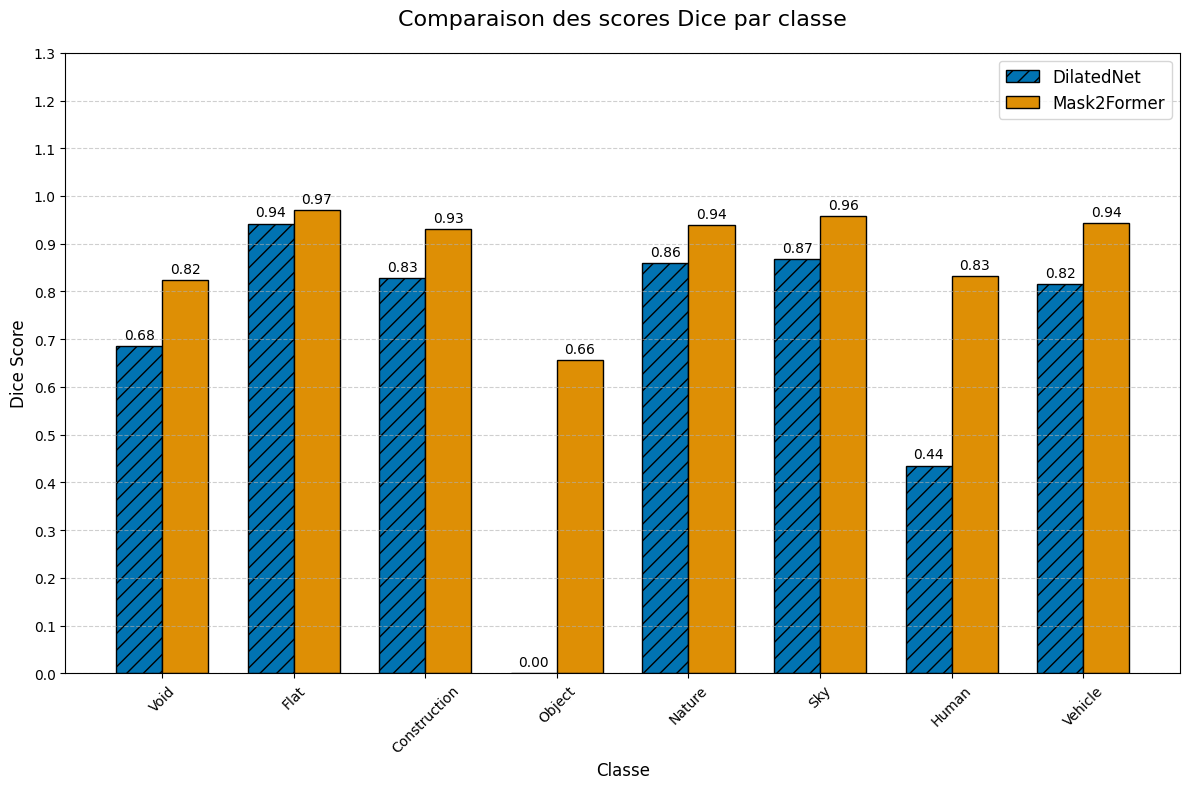

In [97]:
df = results.copy()

# Extraire les meilleures lignes
best_mask2former = df[(df['params.model'] == 'mask2former') & (df['params.training_type'] == 'fine_tuned')].to_dict('records')[0]
best_dilatednet = df[df['params.model'] == 'dilatednet'].to_dict('records')[0]

# Classes à comparer
classes = [
    'metrics.dice_void', 'metrics.dice_flat', 'metrics.dice_construction',
    'metrics.dice_object', 'metrics.dice_nature', 'metrics.dice_sky',
    'metrics.dice_human', 'metrics.dice_vehicle'
]

# Préparation des scores
dilated_scores = [best_dilatednet[cls] for cls in classes]
mask2former_scores = [best_mask2former[cls] for cls in classes]
labels = [cls.split('_')[-1].capitalize() for cls in classes]

# Initialisation
bar_width = 0.35
index = np.arange(len(classes))
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(12, 8))

# Barres DilatedNet avec hachures obliques
bars1 = ax.bar(index, dilated_scores, bar_width, label='DilatedNet', hatch='//', edgecolor='black')
# Barres Mask2Former sans hachures
bars2 = ax.bar(index + bar_width, mask2former_scores, bar_width, label='Mask2Former', edgecolor='black')

# Ajout des annotations
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Réglages esthétiques
ax.set_xlabel('Classe', fontsize=12)
ax.set_ylabel('Dice Score', fontsize=12)
ax.set_title('Comparaison des scores Dice par classe', fontsize=16, pad=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, fontsize=10)
ax.yaxis.set_major_locator(MultipleLocator(0.1))  # Ticks tous les 0.1
ax.set_ylim(0, 1.3)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## Analyse locale : interpréter les prédictions de Mask2Former par query

Dans cette section, nous cherchons à explorer **comment Mask2Former prend ses décisions au niveau local**, c’est-à-dire **à l’échelle d’une image donnée**.

Contrairement aux modèles classiques qui produisent directement une prédiction par pixel, Mask2Former génère une série de **queries**, chacune associée à :
- une **classe sémantique prédite**,
- un **masque binaire** (segment spatial),
- et un **score de confiance**.

Chaque query peut être interprétée comme une tentative du modèle d’**identifier un objet ou une région cohérente** dans l’image.

En visualisant les **masques associés aux queries les plus confiantes**, superposés à l’image d’entrée, nous obtenons une **forme d’interprétabilité locale native** du modèle.  
Cela nous permet de **comprendre quelles parties de l’image déclenchent quelles prédictions**, et **comment le modèle structure sa segmentation interne**.

L’objectif est donc d’analyser :  
- **la cohérence spatiale des masques**,  
- **la spécialisation des queries par classe**,  
- et **le niveau de certitude du modèle** pour chaque segment.

Cette approche complète les métriques chiffrées par une **analyse visuelle qualitative**, essentielle pour comprendre en profondeur les forces et limites de Mask2Former.


In [100]:
def visualize_top_queries_grid(img, outputs, k=6, cols=3):

    class_logits = outputs.class_queries_logits[0]
    mask_logits = outputs.masks_queries_logits[0]

    class_probs = class_logits.softmax(dim=-1)
    pred_classes = class_probs.argmax(dim=-1)
    confidences = class_probs.max(dim=-1).values
    masks = mask_logits.sigmoid().cpu().numpy()

    # Trier les queries par confiance décroissante
    sorted_queries = torch.argsort(confidences, descending=True)

    # Stocker les queries valides
    valid_queries = []
    for q in sorted_queries:
        class_id = pred_classes[q].item()
        if class_id < 8:  # uniquement les vraies classes (0 à 7)
            valid_queries.append(q.item())
        if len(valid_queries) >= k:
            break

    if not valid_queries:
        print("Aucune query n'a prédit une classe valide (0 à 7).")
        return

    # Déterminer la grille (k images max)
    rows = math.ceil(len(valid_queries) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

    if rows == 1:
        axs = [axs]  # un seul rang → liste simple
    axs = np.array(axs).reshape(rows, cols)

    for i, q in enumerate(valid_queries):
        row, col = divmod(i, cols)
        ax = axs[row, col]
        class_id = pred_classes[q].item()
        class_name = cityscapes_classes_8[class_id]

        ax.imshow(img)
        ax.imshow(masks[q], cmap='Reds', alpha=0.5)
        ax.set_title(f"Query {q} → {class_name} (score={confidences[q]:.2f})")
        ax.axis("off")

    # Masquer les cases vides si moins de k images
    for j in range(len(valid_queries), rows * cols):
        row, col = divmod(j, cols)
        axs[row, col].axis("off")

    plt.tight_layout()
    plt.show()

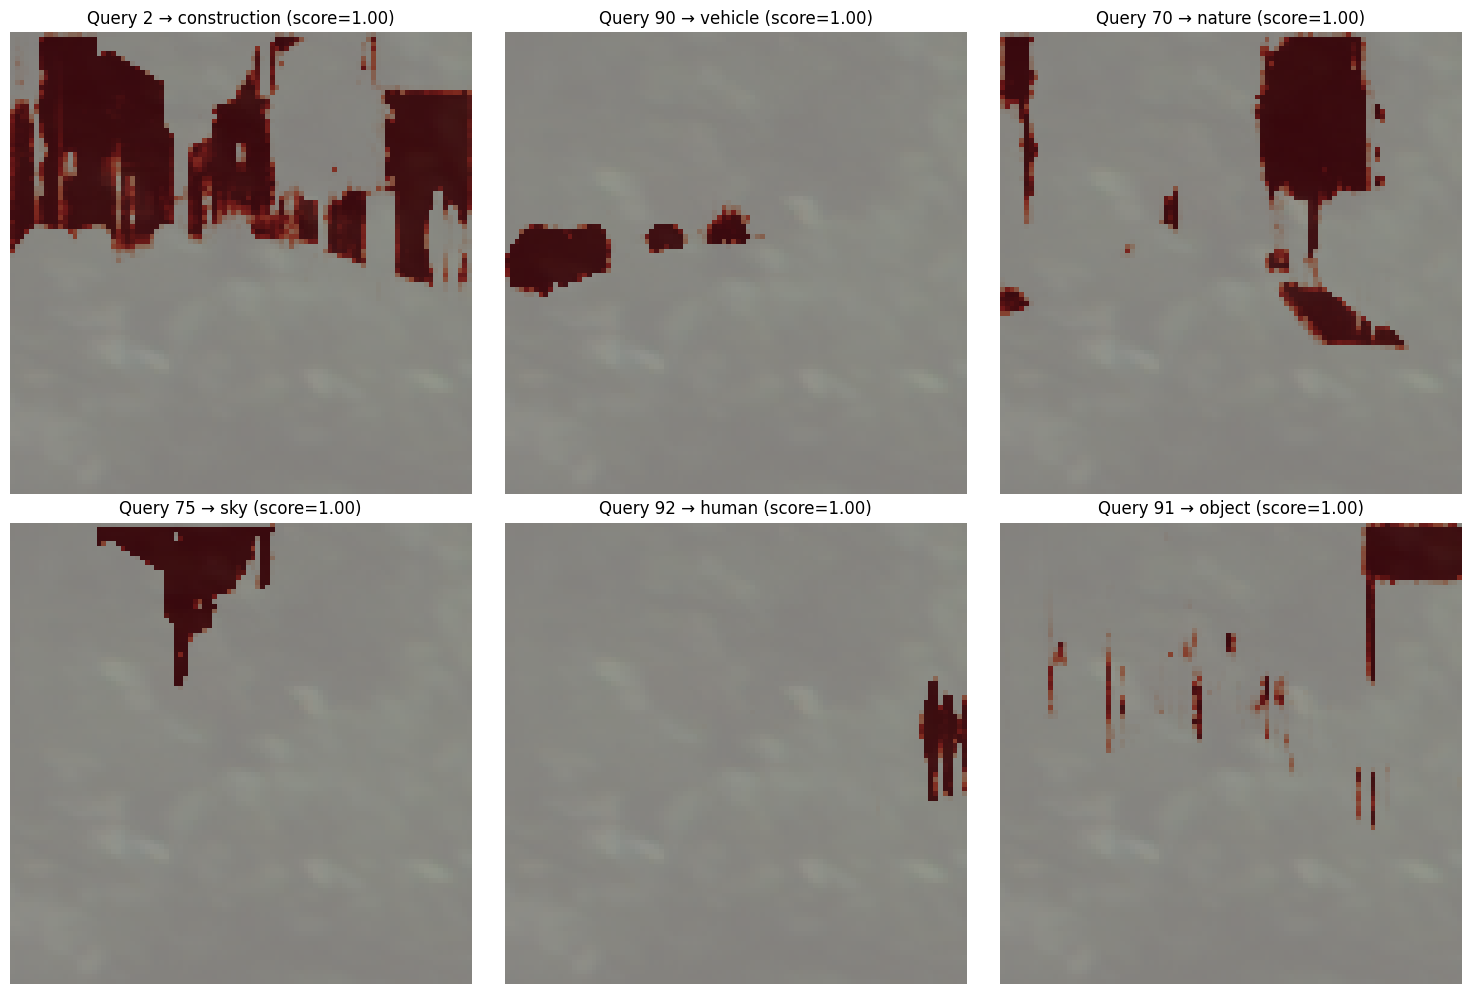

In [102]:
mask2former = Mask2FormerModel(best_model, processor)

img = datasets['test'][img_index_test]['image']
outputs = mask2former.prediction_outputs(datasets['test'], img_index_test)

outputs = visualize_top_queries_grid(img, outputs)

La grille ci-dessus illustre les `k = 6` queries les plus confiantes générées par Mask2Former pour une image du jeu de test Cityscapes.

Chaque case représente :
- Un **masque spatial** (en rouge) produit par une query,
- Superposé à l’image d’origine,
- Avec la **classe prédite** et le **score de confiance** associé.

La visualisation des queries de Mask2Former permet d'accéder à une **interprétation locale directe** des prédictions du modèle.

Chaque query représente une **prédiction segmentée localement**, avec :
- une **classe sémantique associée**,
- un **masque délimitant la région spatiale** concernée,
- et une **confiance mesurable** issue des logits.

En superposant les masques de queries aux images d’entrée, on identifie précisément **quelles zones de l’image ont conduit à la prédiction d’une classe donnée**, ce qui permet d’analyser visuellement le fonctionnement du modèle segment par segment.

Cette capacité est particulièrement intéressante car elle offre une **forme d’interprétabilité native** : pas besoin de rétropropagation ou d’outils externes (comme Grad-CAM). Le mécanisme à base de queries, combiné à l’attention masquée, permet d'expliquer **où et pourquoi** le modèle a pris une décision.


En résumé : cette visualisation permet de **comprendre spatialement et sémantiquement** les décisions du modèle, et donc de renforcer la confiance dans ses prédictions tout en identifiant les éventuelles zones de faiblesse.

## Analyse globale des prédictions de Mask2Former

Afin de mieux comprendre le fonctionnement interne du modèle Mask2Former, nous avons mené une analyse globale sur l’ensemble du jeu de test, en nous appuyant sur trois visualisations complémentaires :

* **Fréquence des classes prédominantes dans les queries** (graphique gauche) : ce graphique permet d'observer quelles classes sont le plus souvent activées en sortie des queries du décodeur, et donc lesquelles le modèle considère comme les plus pertinentes à prédire.

* **Dice moyen par classe** (graphique centre) : cette métrique reflète la qualité moyenne de segmentation par classe, indépendamment de leur fréquence dans le dataset. Elle est calculée à partir des masques finaux du modèle.

* **Score de confiance moyen par query** (graphique droite) : ce graphique synthétise, pour chaque query, le niveau de confiance maximal accordé par le modèle à l’une des classes. Il permet de visualiser le niveau de certitude que Mask2Former attribue à ses prédictions internes.

En croisant ces trois dimensions — **activation interne**, **performance réelle** et **niveau de certitude** —, cette analyse vise à enrichir l’interprétabilité globale du modèle. Elle permet d’identifier des déséquilibres potentiels, des spécialisations implicites et des comportements non attendus.

In [105]:
n_classes = len(cityscapes_classes_8)
n_queries = 100
counts = Counter()
dice_per_class = [[] for _ in range(n_classes)]
query_confidences = [[] for _ in range(n_queries)]

n_samples = len(datasets['test'])

for i in range(n_samples):
    # Sortie brute du modèle (avec class_queries_logits)
    outputs = mask2former.prediction_outputs(datasets['test'], i)
    class_logits = outputs.class_queries_logits[0]  # (num_queries, num_classes)
    class_probs = class_logits.softmax(dim=-1)
    pred_classes = class_probs.argmax(dim=-1).cpu().numpy()

    # Comptage des classes prédominantes
    for c in pred_classes:
        if c < n_classes:
            counts[c] += 1

    # Score max softmax pour chaque query
    for q in range(min(len(class_probs), n_queries)):
        score = class_probs[q].max().item()
        query_confidences[q].append(score)

    # Reconstruction du masque prédit et masque réel
    pred_mask = mask2former.predict(datasets['test'], i)
    gt_mask = datasets['test'][i]['mask']

    # Dice par classe
    for cls in range(n_classes):
        pred_bin = (pred_mask == cls).astype(np.uint8).flatten()
        gt_bin = (gt_mask == cls).astype(np.uint8).flatten()
        intersection = np.sum(pred_bin * gt_bin)
        total = np.sum(pred_bin) + np.sum(gt_bin)
        dice = (2 * intersection) / total if total > 0 else 0.0
        dice_per_class[cls].append(dice)

# Calcul des moyennes
dice_avg = [np.mean(cls_scores) for cls_scores in dice_per_class]
frequencies = [counts.get(i, 0) for i in range(n_classes)]
avg_conf = [np.mean(q) if q else 0 for q in query_confidences]

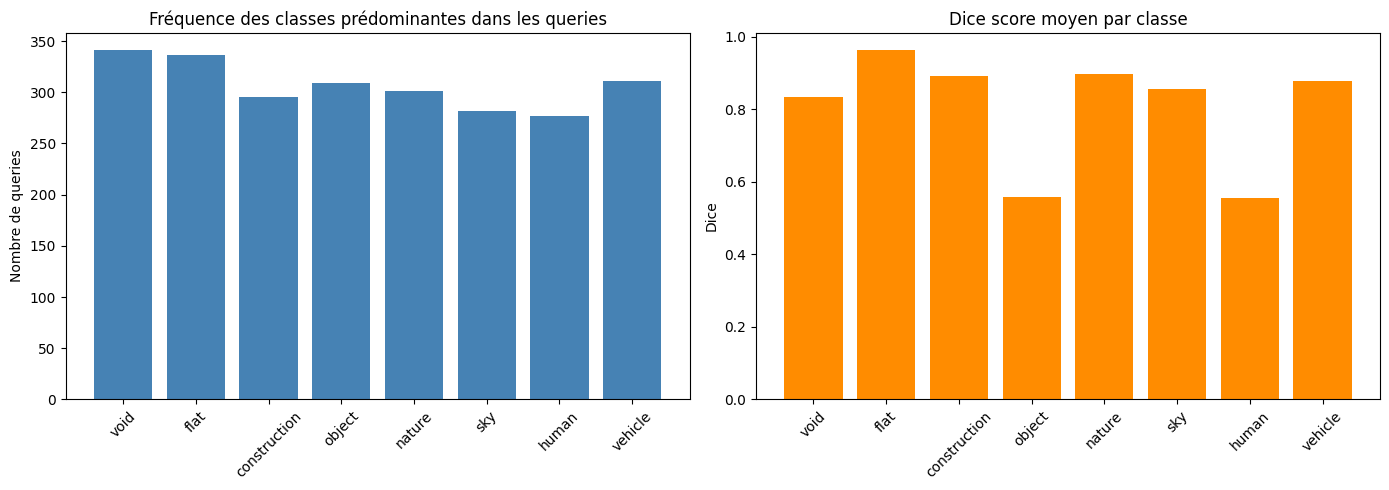

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].bar(cityscapes_classes_8, frequencies, color='steelblue')
axs[0].set_title("Fréquence des classes prédominantes dans les queries")
axs[0].set_ylabel("Nombre de queries")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(cityscapes_classes_8, dice_avg, color='darkorange')
axs[1].set_title("Dice score moyen par classe")
axs[1].set_ylabel("Dice")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("analyse_query.png", dpi=100, bbox_inches='tight')
plt.show()

Les deux histogrammes permettent de croiser la **fréquence d’activation des classes dans les queries** (gauche) avec la **qualité de segmentation (Dice moyen)** par classe (droite).

* La classe `flat` se distingue à la fois par une **fréquence d’activation élevée** dans les queries et un **score Dice très élevé**, ce qui confirme que le modèle est bien spécialisé sur cette classe dominante.

* Les classes `construction`, `nature`, `sky` et `vehicle` présentent un bon compromis entre **activation régulière** et **segmentation précise**, avec des scores Dice autour de 0.85–0.9.

* À l’inverse, les classes `object` et `human` sont à la fois **moins fréquemment activées** et obtiennent les **scores Dice les plus faibles** (autour de 0.55), ce qui suggère une **difficulté du modèle à les segmenter correctement**, probablement en raison d’un **déséquilibre dans les données** ou d’un manque d’attention interne.

* La classe `void` est fortement activée dans les queries, avec un Dice correct (≈ 0.83), ce qui indique que le modèle **réussit généralement à ignorer** les zones non annotées — un comportement cohérent avec les attentes.

Ce type de visualisation met en lumière la **corrélation entre l’attention du modèle (via les queries)** et la **performance réelle par classe**, offrant un outil précieux pour diagnostiquer les **faiblesses structurelles** et **orienter les améliorations ciblées** (rééquilibrage, augmentation de données, etc.).

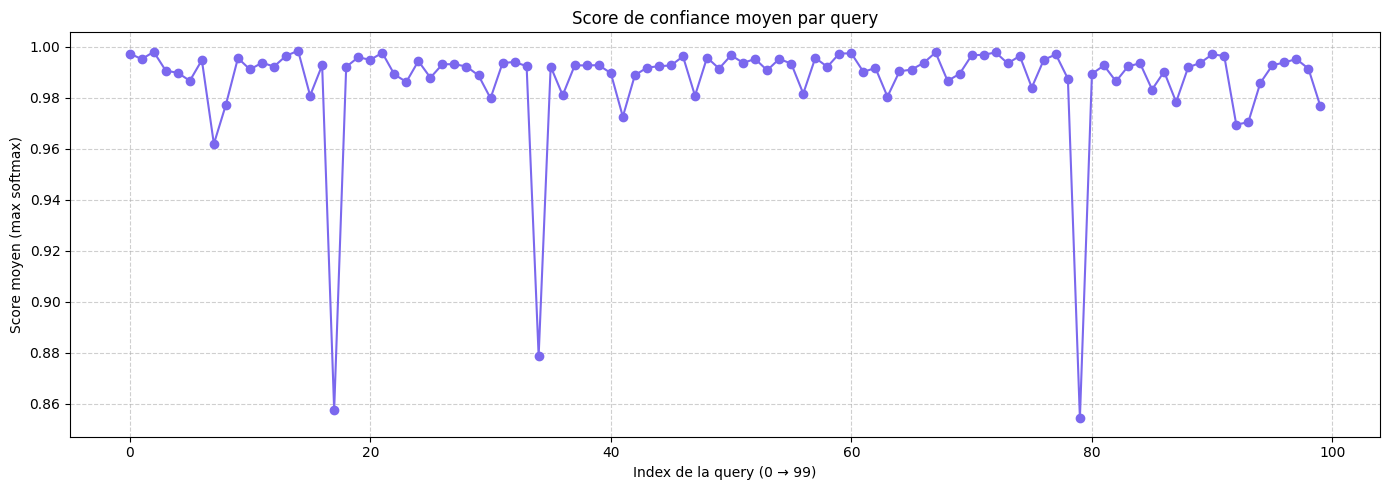

In [107]:
plt.figure(figsize=(14, 5))
plt.plot(avg_conf, marker='o', linestyle='-', color='mediumslateblue')
plt.title("Score de confiance moyen par query")
plt.xlabel("Index de la query (0 → 99)")
plt.ylabel("Score moyen (max softmax)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("score_moyen_query.png", dpi=100, bbox_inches='tight')
plt.show()

Ce graphique représente le **score moyen de confiance (maximum softmax)** attribué par chaque query du décodeur de Mask2Former, sur l'ensemble du jeu de test. Chaque point correspond à la moyenne des scores `max(class_probs)` associés à une query donnée (de 0 à 99).


* La **grande majorité des queries** ont des scores de confiance très élevés, **compris entre 0.97 et 1.00**, ce qui indique que le modèle prend des décisions très affirmées.

* Cependant, on observe **plusieurs chutes nettes** de confiance (notamment vers les indexes 18, 35, 79) avec des scores moyens **sous les 0.90** (jusqu’à \~0.85), ce qui suggère que certaines queries sont **beaucoup moins fiables ou peu activées**.

* Ces queries à faible confiance pourraient correspondre à :

  * des classes mal représentées dans les données,
  * des classes confondues régulièrement,
  * ou simplement à des queries peu spécialisées ou redondantes.


Ce type de visualisation est un **levier d’interprétabilité structurelle** : il permet d’**évaluer la robustesse des queries** individuellement et d’identifier celles qui mériteraient d’être **supprimées, renforcées ou surveillées** lors d’un entraînement plus fin (ex. : distillation, pruning, attention masking…).


## Visualisation comparative des prédictions

### Mask2Former pré-entraîné vs Mask2Former fine-tuné

L’illustration ci-dessous propose une **comparaison visuelle** des résultats obtenus par les deux versions de Mask2Former sur un exemple du jeu de test :

* à gauche, **l’image d’entrée** en couleurs naturelles,
* en deuxième position, le **masque de vérité terrain** (annotations Cityscapes remappées en 8 classes),
* puis, la **prédiction du modèle pré-entraîné** sans aucune mise à jour des poids,
* enfin, la **prédiction du modèle fine-tuné**, adapté spécifiquement à notre tâche.

Cette visualisation permet d’observer les effets concrets du fine-tuning, en particulier une meilleure segmentation des objets complexes ou des zones peu représentées initialement.

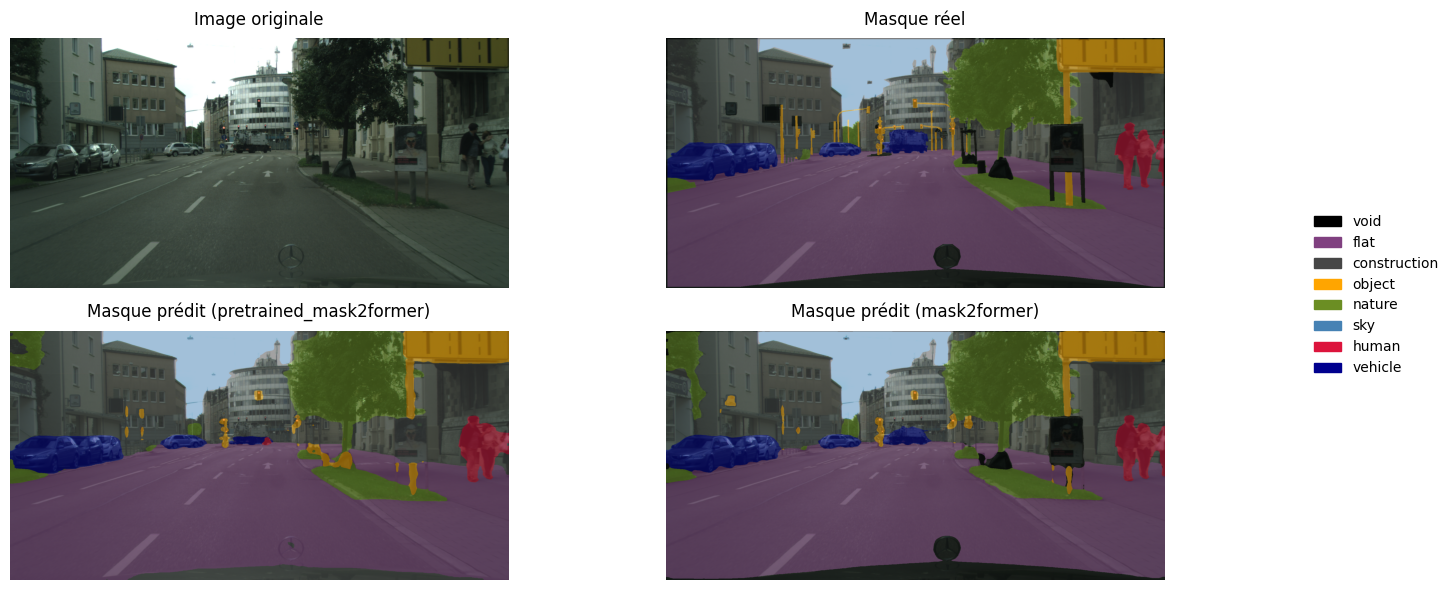

In [116]:
mask = datasets['test'][img_index_test]['mask']

img = datasets['test'][img_index_test]['image']
img = Image.fromarray(img.astype(np.uint8))

pretrained_mask2former = Mask2FormerModel(pretrained_model, processor)
pred_pretrained_mask2former = pretrained_mask2former.predict(datasets['test'], img_index_test)
pred_pretrained_mask2former = remap_cityscapes_to_8classes(pred_pretrained_mask2former)
pred_mask2former_rgb = create_color_mask(pred_pretrained_mask2former, cityscapes_palette_8)

mask2former = Mask2FormerModel(best_model, processor)
pred_mask2former = mask2former.predict(datasets['test'], img_index_test)
pred_mask2former_rgb = create_color_mask(pred_mask2former, cityscapes_palette_8)

fig = plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Image originale", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(blend(img, mask, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque réel", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(blend(img, pred_pretrained_mask2former, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque prédit (pretrained_mask2former)", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(blend(img, pred_mask2former, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque prédit (mask2former)", fontsize=12, pad=10)
plt.axis("off")

handles = [mpatches.Patch(color=np.array(c)/255.0, label=label) for c, label in zip(cityscapes_palette_8, cityscapes_classes_8)]
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

On observe clairement les bénéfices du fine-tuning :

* Contrairement au modèle pré-entraîné, le modèle fine-tuné parvient à **identifier correctement les zones appartenant à la classe `void`**, représentées en noir. Cela est essentiel pour éviter de classer ces zones comme des objets erronés.
* Les prédictions du modèle fine-tuné sont également **plus précises sur les contours** des objets, avec moins de flou ou de débordement entre les classes.
* On note une **meilleure cohérence globale** avec le masque réel, en particulier sur les classes dominantes comme **la route (mauve)**, **le ciel (bleu clair)** et **les bâtiments (gris foncé)**.

Cette comparaison qualitative met en lumière **l’intérêt d’un fine-tuning ciblé**, qui permet au modèle de prendre en compte des classes absentes de son entraînement initial et d’affiner ses prédictions sur des données spécifiques.


### DilatedNet vs Mask2Former fine-tuné

L'objectif maintenant est de **recharger et utiliser le modèle `DilatedNet` sauvegardé via MLflow**, afin de l'intégrer à notre pipeline de comparaison avec Mask2Former.

Plus précisément :

* Le modèle est restauré à l’aide de `mlflow.keras`, en spécifiant les fonctions de perte et de métrique personnalisées (`dice_coeff`, `total_loss`) utilisées lors de l'entraînement.
* Il est recompilé avec l’optimiseur `Adam` et les mêmes paramètres que ceux utilisés lors du fine-tuning initial.

In [119]:
# Fonction Dice
def dice_coeff(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coeff(y_true, y_pred)

# Combinaison des deux pertes
def total_loss(y_true, y_pred):
    ce = CategoricalCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return ce + 3 * dl
    
# Charger le modèle en fournissant les objets personnalisés
logged_model_uri = "runs:/ea29351355114229b5159bbd067bc04b/dilatednet" 
local_model_path = f"{mlflow.artifacts.download_artifacts(logged_model_uri)}\data\model"

dilatednet_model = load_model(local_model_path, custom_objects={"dice_coeff": dice_coeff, "total_loss": total_loss})
dilatednet_model.compile(optimizer=Adam(1e-4), loss=total_loss, metrics=[dice_coeff, 'accuracy'])

Une classe utilitaire `DilatedNetModel` est ensuite définie pour faciliter les prédictions :

* Elle prend en charge le **prétraitement de l’image** (redimensionnement, normalisation, ajout d’une dimension batch).
* Elle effectue la prédiction sur une image issue du dataset et **reprojette le résultat à la taille d’origine**, avec interpolation bilinéaire.
* La sortie finale est une carte de segmentation à 8 classes, obtenue via un `argmax` pixel à pixel sur les scores de classes.

Cette interface standardisée permet d’utiliser `DilatedNet` de la même manière que `Mask2Former`, en vue d’une **comparaison équitable des performances**.

In [121]:
# Classe pour effectuer des prédictions avec un modèle DilatedNet (Keras)
class DilatedNetModel:
    def __init__(self, model, img_size=(256, 256)):
        # Initialisation du modèle et de la taille des images attendues par le modèle
        self.model = model
        self.img_size = img_size

    def preprocess(self, input_img):
        # Redimensionnement de l'image à la taille d'entrée du modèle
        img = input_img.resize(self.img_size)
        # Conversion en tableau numpy et normalisation des pixels (entre 0 et 1)
        img = np.array(img).astype(np.float32) / 255.0
        # Ajout d'une dimension batch (1, H, W, C)
        return np.expand_dims(img, axis=0)

    def predict(self, dataset, index):
        # Récupération de l'image à partir du dataset
        img = dataset[index]['image']
        # Conversion en image PIL (requis par preprocess)
        img = Image.fromarray(img.astype(np.uint8))
        # Récupération de la taille d'origine pour re-projeter la sortie à cette taille
        original_size = dataset[index]['original_size']
        # Prétraitement pour le modèle
        input_img = self.preprocess(img)
        # Prédiction du modèle (logits pour chaque classe)
        prediction = self.model.predict(input_img)
        # Reshape pour retrouver la forme (H, W, C) à partir du batch
        reshaped = prediction[0].reshape((self.img_size[0], self.img_size[1], 8))
        # Redimensionnement à la taille d’origine avec interpolation bilinéaire
        resized_logits = tf.image.resize(reshaped, original_size, method="bilinear").numpy()
        # Calcul du masque final par argmax sur les logits (classe avec proba max)
        predicted_mask = np.argmax(resized_logits, axis=-1)
        return predicted_mask

Cette visualisation permet de comparer les performances qualitatives des deux modèles étudiés :

* `DilatedNet` (modèle baseline, en bas à gauche),
* `Mask2Former` (modèle fine-tuné, en bas à droite),

par rapport :

* à l’image d’entrée (en haut à gauche),
* et au masque de vérité terrain (`ground-truth`, en haut à droite).

1/1 [==============================] - 1s 805ms/step


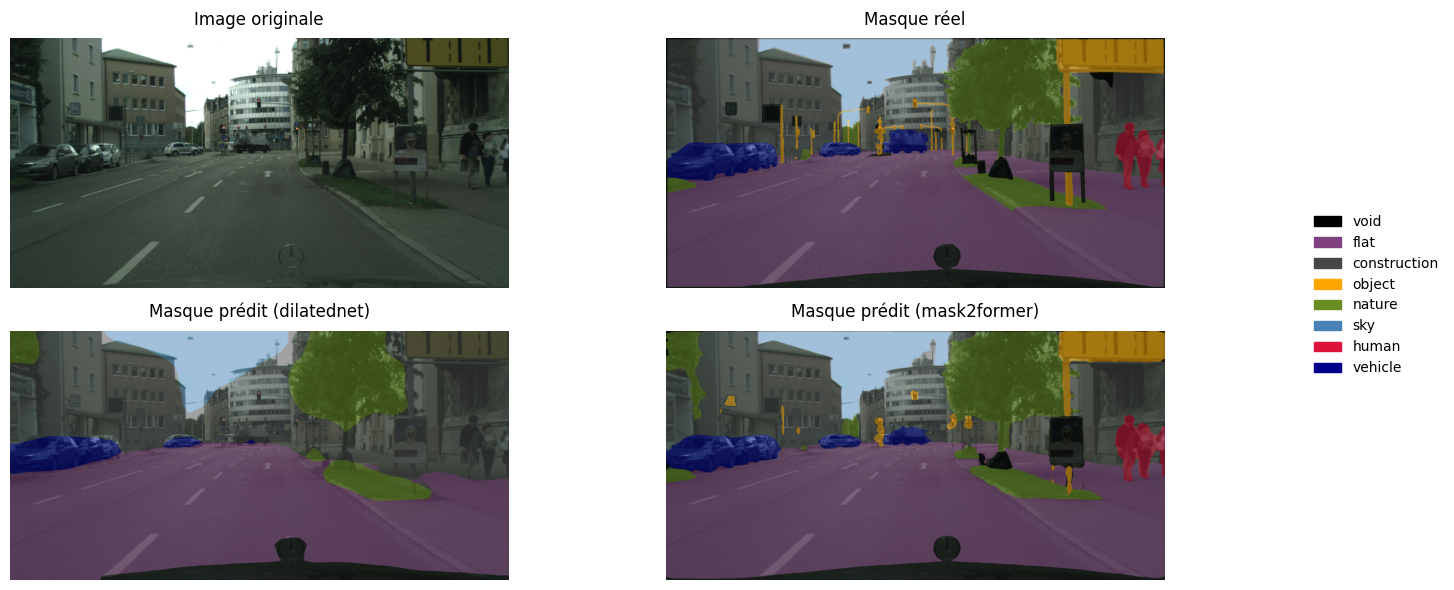

In [123]:
mask = datasets['test'][img_index_test]['mask']

img = datasets['test'][img_index_test]['image']
img = Image.fromarray(img.astype(np.uint8))

dilatednet = DilatedNetModel(dilatednet_model)
pred_dilated = dilatednet.predict(datasets['test'], img_index_test)
pred_dilated_rgb = create_color_mask(pred_dilated, cityscapes_palette_8)

mask2former = Mask2FormerModel(best_model, processor)
pred_mask2former = mask2former.predict(datasets['test'], img_index_test)
pred_mask2former_rgb = create_color_mask(pred_mask2former, cityscapes_palette_8)

fig = plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Image originale", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(blend(img, mask, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title("Masque réel", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(blend(img, pred_dilated, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title(f"Masque prédit (dilatednet)", fontsize=12, pad=10)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(blend(img, pred_mask2former, cityscapes_palette_8), cmap=cmap_cityscapes_8, vmin=0, vmax=7)
plt.title(f"Masque prédit (mask2former)", fontsize=12, pad=10)
plt.axis("off")

handles = [mpatches.Patch(color=np.array(c)/255.0, label=label) for c, label in zip(cityscapes_palette_8, cityscapes_classes_8)]
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.01, 0.5), fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

On peut tirer plusieurs observations clés :

* Le modèle **Mask2Former fine-tuné** parvient à **segmenter correctement la classe `void`** (en noir), notamment sur les bordures, ce que **DilatedNet n’arrive pas à faire**, en raison de son architecture moins expressive.
* La **segmentation des véhicules** est plus précise avec `Mask2Former`, qui détecte mieux les contours et sépare mieux les instances rapprochées.
* Les **classes dominantes** comme `flat` (mauve) pour la route ou `nature` (vert) pour les arbres sont bien apprises par les deux modèles, mais `Mask2Former` affiche des **contours plus nets**.
* Contrairement à `DilatedNet`, **Mask2Former distingue également des classes plus fines comme `object` (orange) et `human` (rouge)**, démontrant une meilleure sensibilité aux petits objets ou objets isolés.

# Conclusion

Ce projet avait pour objectif d’évaluer les apports d’un modèle récent de segmentation sémantique, **Mask2Former**, en le comparant à un modèle plus classique, **DilatedNet**, utilisé dans un projet antérieur.

L’analyse s’est déroulée en plusieurs étapes :

* L’évaluation du **modèle préentraîné Mask2Former**, sans fine-tuning, a permis d’obtenir une première baseline de performance sur notre version 8 classes du dataset **Cityscapes**.
* Un **fine-tuning supervisé** sur nos données a ensuite été réalisé, avec deux variantes : un **entraînement complet** du modèle, et un entraînement **avec le backbone gelé**, afin de mesurer l’impact de cette stratégie sur les performances.
* Les résultats obtenus ont été comparés aux performances du modèle **DilatedNet**, préalablement entraîné sur la même structure d’annotations.

Les enseignements tirés de cette expérimentation sont les suivants :

* **Mask2Former fine-tuné (backbone libre ou gelé) surpasse largement DilatedNet**, tant sur le plan qualitatif que quantitatif (meilleur score Dice global, meilleure précision par classe).
* Le modèle préentraîné est déjà robuste sur certaines classes dominantes, mais son incapacité à reconnaître la classe `void` justifie l’intérêt du fine-tuning.
* L’entraînement avec backbone gelé donne des résultats très proches du fine-tuning complet, tout en réduisant le risque de surapprentissage et le temps de calcul.
* La classe `object`, souvent sous-représentée, reste difficile à segmenter, mais Mask2Former montre une meilleure capacité à la détecter que DilatedNet.
* Enfin, les visualisations montrent que Mask2Former produit des **masques plus précis, plus nets**, et qu’il **gère mieux les classes fines** et les **petites structures**.